# Plot decoding results

In [70]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import sklearn as sk
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate
from DR_analysis_utils import compute_block_modulation

%matplotlib notebook

In [5]:
# ['MOs','ACA']+['all']

In [4]:
loadpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\by_session\use_25_units'

svc_results={}
decoder_results=os.listdir(loadpath)

for ii,ff in enumerate(decoder_results):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results[ii]=pickle.load(handle)
    print(ff)

626791_1decoder_results_200ms_incl_pre_post_all_units.pkl
626791_2decoder_results_200ms_incl_pre_post_all_units.pkl
626791_3decoder_results_200ms_incl_pre_post_all_units.pkl
636766_1decoder_results_200ms_incl_pre_post_all_units.pkl
636766_2decoder_results_200ms_incl_pre_post_all_units.pkl
636766_3decoder_results_200ms_incl_pre_post_all_units.pkl
636766_4decoder_results_200ms_incl_pre_post_all_units.pkl
644864_1decoder_results_200ms_incl_pre_post_all_units.pkl
644864_2decoder_results_200ms_incl_pre_post_all_units.pkl
644864_3decoder_results_200ms_incl_pre_post_all_units.pkl
644864_4decoder_results_200ms_incl_pre_post_all_units.pkl
644866_2decoder_results_200ms_incl_pre_post_all_units.pkl
644866_3decoder_results_200ms_incl_pre_post_all_units.pkl
644866_4decoder_results_200ms_incl_pre_post_all_units.pkl
644867_1decoder_results_200ms_incl_pre_post_all_units.pkl
644867_2decoder_results_200ms_incl_pre_post_all_units.pkl
644867_3decoder_results_200ms_incl_pre_post_all_units.pkl
644867_4decode

In [22]:
svc_results[0].keys()

dict_keys(['metadata', 'trial_numbers', 'unit_numbers', 'min_n_units', 'n_repeats', 'time_bins', 'balance_labels', 'block_ids'])

In [8]:
# svc_results[0]

In [6]:
session_areas=[]
p='block_ids'
for sel_session in range(0,len(svc_results)):
    session_areas.append(list(svc_results[sel_session][p].keys()))
    
unique_areas=np.unique(np.hstack(session_areas))
unique_areas

array(['', 'ACB', 'AId', 'APN', 'AUDp', 'AUDpo', 'CA1', 'CA3', 'CL', 'CP',
       'DG', 'ILA', 'LD', 'LGd', 'LP', 'LSr', 'MB', 'MGd', 'MGm', 'MGv',
       'MOp', 'MOs', 'MRN', 'ORBm', 'PO', 'POL', 'PoT', 'ProS', 'RSPagl',
       'RSPd', 'RSPv', 'SAG', 'SGN', 'SNr', 'SSp-bfd', 'SSp-m', 'SSp-tr',
       'SSp-ul', 'SSp-un', 'SUB', 'TEa', 'VISa', 'VISal', 'VISam', 'VISl',
       'VISli', 'VISp', 'VISpm', 'VISpor', 'VISrl', 'VPL', 'VPM', 'all'],
      dtype='<U7')

In [7]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}
plot_shuffle_results={}
predict_perf={}
predict_perf_shuffle={}
predict_perf_tridx={}
dec_func={}
dec_func_shuffle={}

timepoints=svc_results[0]['time_bins'][1:]

label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

# areas=['VISp','AUD','LG','MG','MOs','MRN','CP','MOp']
areas=unique_areas

for sel_session in range(0,len(svc_results)):
    plot_results[sel_session]={}
    plot_shuffle_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        plot_shuffle_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            plot_shuffle_results[sel_session][aa][p]={}
            for ll in label_list:
                plot_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                plot_results[sel_session][aa][p][ll][:]=np.nan
                
                plot_shuffle_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                plot_shuffle_results[sel_session][aa][p][ll][:]=np.nan
    
# predict_perf=np.zeros((len(trial_sel),n_repeats))
# for nn in range(0,n_repeats):
#     predict_perf[:,nn]=(svc_results[sel_session]['block_ids'][sel_session][p][aa][tt][nn]['cr']['pred_label']==
#                        svc_results[sel_session]['block_ids'][sel_session][p][aa][tt][nn]['cr']['true_label'])
for sel_session in range(0,len(svc_results)):
    predict_perf[sel_session]={}
    predict_perf_shuffle[sel_session]={}
    predict_perf_tridx[sel_session]={}
    dec_func[sel_session]={}
    dec_func_shuffle[sel_session]={}
    for aa in areas:
        if aa in svc_results[sel_session][p].keys():
            predict_perf[sel_session][aa]={}
            predict_perf_shuffle[sel_session][aa]={}
            predict_perf_tridx[sel_session][aa]={}
            dec_func[sel_session][aa]={}
            dec_func_shuffle[sel_session][aa]={}
            for p in predict:
                predict_perf[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                predict_perf_shuffle[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                predict_perf_tridx[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                
                if 'decision_function' in svc_results[sel_session][p][aa][0][0].keys():
                    dec_func[sel_session][aa][p]=svc_results[sel_session][p][aa][0][0]['decision_function']
                    dec_func_shuffle[sel_session][aa][p]=svc_results[sel_session][p][aa][0][0]['shuffle']['decision_function']
                
                for nn in range(0,svc_results[sel_session]['n_repeats']):
                    if len(svc_results[sel_session][p][aa])>0:
                        if len(svc_results[sel_session][p][aa][0])>0:

                                predict_perf[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['pred_label']=='vis1')
#                                     svc_results[sel_session][p][aa][0][nn]['true_label'])

                                predict_perf_shuffle[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['shuffle']['pred_label']=='vis1')
#                                     svc_results[sel_session][p][aa][0][nn]['shuffle']['true_label'])

                                predict_perf_tridx[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['trial_sel_idx'])
    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
decoder_acc_session_shuffle_mean = {}
for aa in areas:
    decoder_acc_session_mean[aa]={}
    decoder_acc_session_shuffle_mean[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        decoder_acc_session_shuffle_mean[aa][p]={}
        for ll in label_list:
            
            decoder_acc_session_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(svc_results)))
            decoder_acc_session_mean[aa][p][ll][:]=np.nan
            
            decoder_acc_session_shuffle_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(svc_results)))
            decoder_acc_session_shuffle_mean[aa][p][ll][:]=np.nan
        

for sel_session in range(0,len(svc_results)):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for nn in range(0,svc_results[sel_session]['n_repeats']):
                        for ll in label_list:
                            if len(svc_results[sel_session][p][aa])>0:
                                if len(svc_results[sel_session][p][aa][tt])>0:
                                    if ll in svc_results[sel_session][p][aa][tt][nn]['cr'].keys():
                                        temp_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_results[sel_session][aa][p][ll][tt,nn]=temp_perf
                                        
                                        temp_shuff_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['shuffle']['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_shuffle_results[sel_session][aa][p][ll][tt,nn]=temp_shuff_perf

                    for ll in label_list:
                        if len(svc_results[sel_session][p][aa])>0:                    
                            decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_mean[aa][p][ll][tt,sel_session] = decoder_acc_mean
    
                            decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_shuffle_mean[aa][p][ll][tt,sel_session] = decoder_acc_shuffle_mean
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

In [12]:
# plot_results[session][area][predict_var][label/stimulus][timepoint_idx,n_repeats]

In [8]:
svc_results[0][p]['CP'][0][0]['cr']['vis1'][['precision','recall']].values

array([0.70666667, 0.81538462])

In [10]:
plot_results[sel_session][aa][p]['vis1']

array([[0.8000989 , 0.82942217, 0.7962627 , 0.80768439, 0.79324429,
        0.80232777, 0.82514277, 0.80907662, 0.79030652, 0.7974094 ,
        0.80128032, 0.81531205, 0.79870283, 0.81277969, 0.81663808,
        0.79245283, 0.79486291, 0.79472276, 0.79656947, 0.80529588,
        0.80903416, 0.81510925, 0.81663808, 0.816901  , 0.80388244,
        0.8173287 , 0.81428471, 0.78719677, 0.78254535, 0.81531205,
        0.80907662, 0.81956046, 0.79092026, 0.80979572, 0.80769231,
        0.79167803, 0.79017296, 0.78948484, 0.79773442, 0.81440562,
        0.79781453, 0.80528863, 0.79804635, 0.8255421 , 0.80754717,
        0.79245283, 0.80544911, 0.82615182, 0.78740134, 0.81628368,
        0.80613027, 0.80377358, 0.80006988, 0.80232777, 0.76748856,
        0.80254275, 0.81843193, 0.80926641, 0.80528863, 0.78719677,
        0.79017994, 0.80926641, 0.7962627 , 0.79319458, 0.80458015,
        0.78806772, 0.79925389, 0.8       , 0.79773442, 0.80682976,
        0.78261149, 0.80754717, 0.80528863, 0.79

In [11]:
temp_perf

0.8119208788769905

In [12]:
# np.mean(predict_perf[sel_session][aa][p],axis=1)
# svc_results[sel_session][p][aa][0][nn]['trial_sel_idx']
svc_results[0][p][aa][0][nn].keys()

dict_keys(['cr', 'pred_label', 'true_label', 'trial_sel_idx', 'trials_used', 'decision_function', 'coefs', 'classes', 'intercept', 'params', 'shuffle', 'unit_sel_idx'])

In [13]:
sel_session

21

<IPython.core.display.Javascript object>


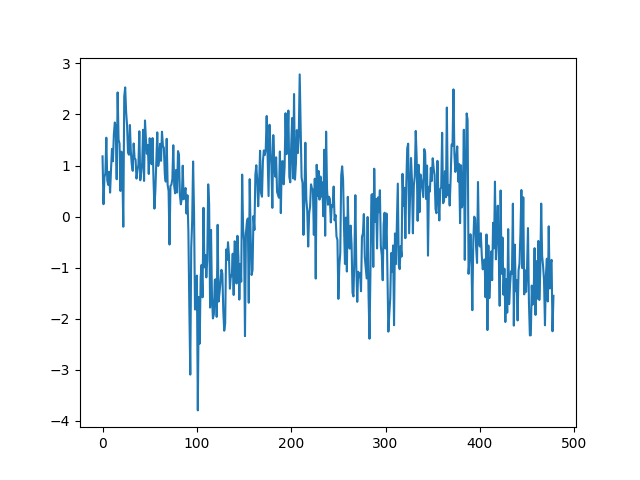

In [18]:
fig,ax=plt.subplots()
ax.plot(dec_func[0]['all']['block_ids'])


<IPython.core.display.Javascript object>


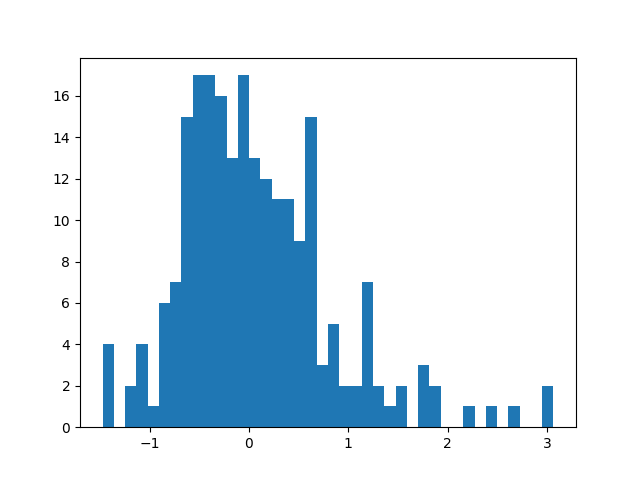

(array([ 4.,  0.,  2.,  4.,  1.,  6.,  7., 15., 17., 17., 16., 13., 17.,
        13., 12., 11., 11.,  9., 15.,  3.,  5.,  2.,  2.,  7.,  2.,  1.,
         2.,  0.,  3.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         2.]),
 array([-1.47406899e+00, -1.36057380e+00, -1.24707861e+00, -1.13358342e+00,
        -1.02008824e+00, -9.06593047e-01, -7.93097858e-01, -6.79602669e-01,
        -5.66107480e-01, -4.52612291e-01, -3.39117101e-01, -2.25621912e-01,
        -1.12126723e-01,  1.36846580e-03,  1.14863655e-01,  2.28358844e-01,
         3.41854033e-01,  4.55349222e-01,  5.68844411e-01,  6.82339600e-01,
         7.95834789e-01,  9.09329978e-01,  1.02282517e+00,  1.13632036e+00,
         1.24981555e+00,  1.36331073e+00,  1.47680592e+00,  1.59030111e+00,
         1.70379630e+00,  1.81729149e+00,  1.93078668e+00,  2.04428187e+00,
         2.15777706e+00,  2.27127225e+00,  2.38476744e+00,  2.49826263e+00,
         2.61175781e+00,  2.72525300e+00,  2.83874819e+00,  2.95224338e+00,
      

In [19]:
fig,ax=plt.subplots()
ax.hist(dec_func[6]['MOs']['block_ids'],bins=40)

In [16]:
np.std(dec_func[4]['MOs']['block_ids'])

0.8775102228872592

In [17]:
X=dec_func[3]['MOs']['block_ids']

fract=0.5

# np.mean((X<-np.std(X))|(X>np.std(X)))
np.mean((X>(-np.std(X)*fract))&(X<(np.std(X)*fract)))

0.41284403669724773

<IPython.core.display.Javascript object>


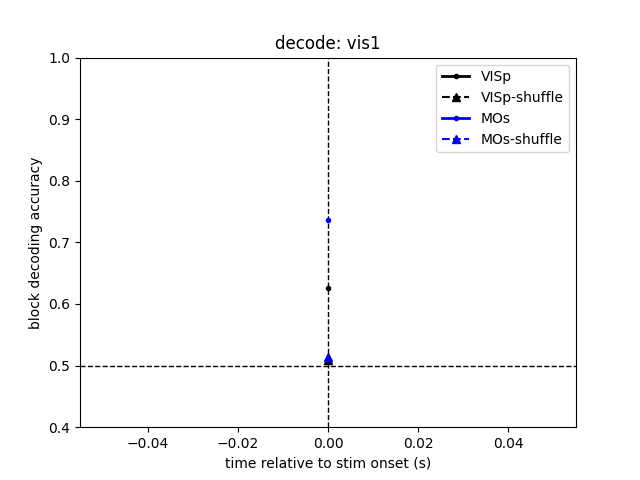

In [31]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=1)

# ax.plot(time_bins[1:],decoder_acc_session_mean['VISp'][predict_var][sel_stim],'k',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['AUDp'][predict_var][sel_stim],'m',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MOs'][predict_var][sel_stim],'b',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MRN'][predict_var][sel_stim],'r',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['CP'][predict_var][sel_stim],'g',linewidth=0.75,alpha=0.5)


visp_line=ax.plot(timepoints,np.nanmean(decoder_acc_session_mean['VISp'][predict_var][sel_stim],axis=1)
        ,'k.-',linewidth=2)

visp_line_balance_running=ax.plot(timepoints,
                                  np.nanmean(decoder_acc_session_shuffle_mean['VISp'][predict_var][sel_stim],axis=1)
                                  ,'k^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['AUDp'][predict_var][sel_stim],axis=1)
#         ,'m.-',linewidth=2)
mos_line=ax.plot(timepoints,np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
        ,'b.-',linewidth=2)

mos_line_balance_running=ax.plot(timepoints,
                                  np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
                                  ,'b^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MRN'][predict_var][sel_stim],axis=1)
#         ,'r.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['CP'][predict_var][sel_stim],axis=1)
#         ,'g.-',linewidth=2)


ax.set_ylim([0.4,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('block decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
          ['VISp','VISp-shuffle','MOs','MOs-shuffle'])

<IPython.core.display.Javascript object>


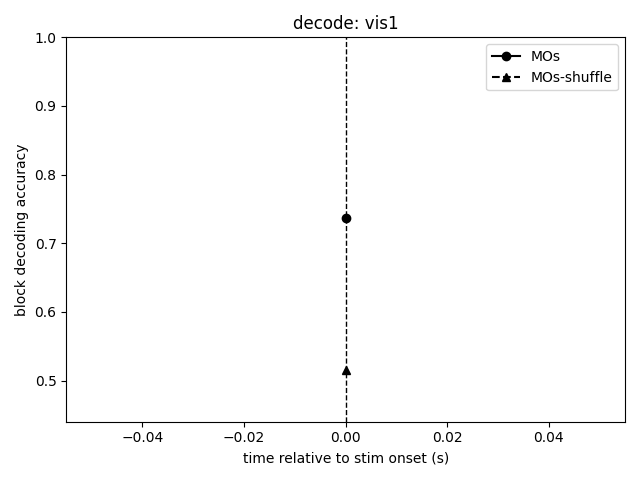

In [32]:
#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')
    
ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],['MOs','MOs-shuffle'])
fig.tight_layout()

<IPython.core.display.Javascript object>


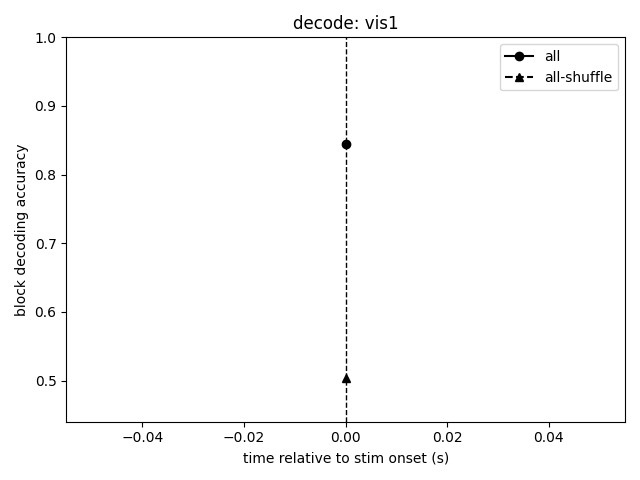

In [33]:
#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'
sel_area='all'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean[sel_area][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')
    
ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],[sel_area,sel_area+'-shuffle'])
fig.tight_layout()

<IPython.core.display.Javascript object>


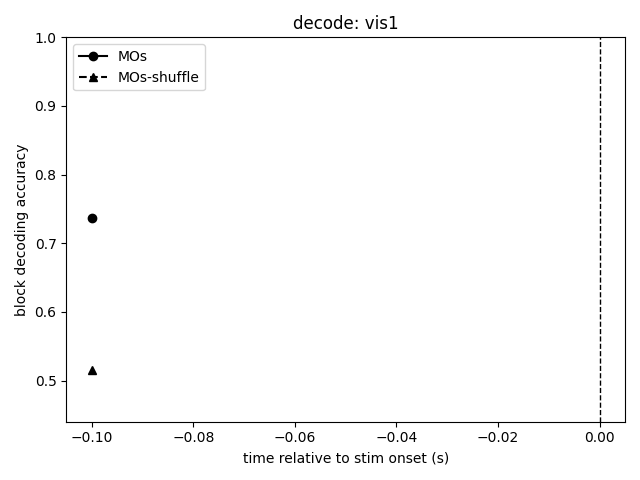

In [34]:
#shift bins plot position - try with and without connecting lines

predict_var='block_ids'
sel_stim='vis1'

timepoint_midpoints=(svc_results[0]['time_bins'][1:]+svc_results[0]['time_bins'][:-1])/2

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoint_midpoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoint_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')
# l1=ax.errorbar(timepoint_midpoints, y1, err1, color='k',linestyle='',marker='o')

y2=np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoint_midpoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoint_midpoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')
# l2=ax.errorbar(timepoint_midpoints, y2, err2, color='k',linestyle='',marker='^')

if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')

ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],['MOs','MOs-shuffle'])
fig.tight_layout()

In [34]:
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    #some error with this one's processing ^
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]

In [71]:
#load all sessions

sessions={}

for mi,mm in enumerate(main_path):
    sessions[mi]=Session(path=mm)
    sessions[mi].assign_unit_areas()
    sessions[mi]=compute_smoothed_response_rate(sessions[mi])


AttributeError: 'Session' object has no attribute 'trial_da'

In [72]:
# loop through sessions and make unit xarrays
time_before_flash = 0.25
trial_duration = 1
bin_size = 0.001


for ss in sessions:
    #Make tensor
    trial_tensor = make_neuron_time_trials_tensor(sessions[ss].good_units, sessions[ss].spike_times, 
                                                  sessions[ss].trials,time_before_flash, trial_duration, 
                                                  bin_size)

    # make xarray
    sessions[ss].trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": sessions[ss].good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": sessions[ss].trials.index.values
                                   })
    
    sessions[ss] = compute_block_modulation(sessions[ss])
    
    print(main_path[ss]+' done')

\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed done


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1689: RuntimeWarning: invalid value encountered in double_scalars
  pre_block_diff_avg[ui]=((np.nanmean(pre_stim_sel_unit_vis.values)-np.nanmean(pre_stim_sel_unit_aud.values))/


\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed done
\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed done


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1689: RuntimeWarning: invalid value encountered in double_scalars
  pre_block_diff_avg[ui]=((np.nanmean(pre_stim_sel_unit_vis.values)-np.nanmean(pre_stim_sel_unit_aud.values))/
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1689: RuntimeWarning: invalid value encountered in double_scalars
  pre_block_diff_avg[ui]=((np.nanmean(pre_stim_sel_unit_vis.values)-np.nanmean(pre_stim_sel_unit_aud.values))/


\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed done
\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed done
Y:\DRpilot_644866_20230208\processed done
Y:\DRpilot_644866_20230209\processed done
Y:\DRpilot_644866_20230210\processed done
Y:\DRpilot_644867_20230220\processed done
Y:\DRpilot_644867_20230221\processed done
Y:\DRpilot_644867_20230222\processed done
Y:\DRpilot_644867_20230223\processed done
Y:\DRpilot_649943_20230213\processed done
Y:\DRpilot_649943_20230214\processed done


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1694: RuntimeWarning: invalid value encountered in double_scalars
  stim_block_diff_avg[ui]=((np.nanmean(stim_sel_unit_vis.values)-np.nanmean(stim_sel_unit_aud.values))/
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1694: RuntimeWarning: invalid value encountered in double_scalars
  stim_block_diff_avg[ui]=((np.nanmean(stim_sel_unit_vis.values)-np.nanmean(stim_sel_unit_aud.values))/


Y:\DRpilot_649943_20230215\processed done
Y:\DRpilot_649943_20230216\processed done


In [36]:
sessions[0].trials.columns

Index(['trialStartFrame', 'trialStimID', 'trialstimRewarded', 'trial_response',
       'trial_rewarded', 'trial_sound_dur', 'trial_vis_stim_dur',
       'vis_go_trials', 'vis_nogo_trials', 'vis_hit_trials',
       'vis_false_alarm_trials', 'vis_miss_trials',
       'vis_correct_reject_trials', 'vis_autoreward_trials', 'aud_go_trials',
       'aud_nogo_trials', 'aud_hit_trials', 'aud_false_alarm_trials',
       'aud_miss_trials', 'aud_correct_reject_trials', 'aud_autoreward_trials',
       'catch_trials', 'catch_resp_trials', 'trialStimStartFrame',
       'stimStartTime', 'stimLatency', 'trial_stim_dur', 'avg_run_speed'],
      dtype='object')

In [37]:
# load trials from all sessions and get probability of licking for visual vs. auditory target

trial_info={}

#save trialStimID, trial_response

#make vis_target_response and aud_target_response vectors
#regardless of block!

for ss in sessions:
    trial_info[ss]={}
    
    block_transitions=np.where(
        sessions[ss].trials['trialstimRewarded'][:-1].values!=
        sessions[ss].trials['trialstimRewarded'][1:].values)[0]+1
    block_transitions=np.hstack([0,block_transitions,len(sessions[ss].trials)-1])

    block_number=np.zeros(len(sessions[ss].trials))
    block_number[:]=np.nan

    for bb in range(1,len(block_transitions)):
        block_number[block_transitions[bb-1]:block_transitions[bb]]=bb

    sessions[ss].trials['block_number']=block_number
    
    
    if 'trialOptoVoltage' in sessions[ss].trials.columns:
        trial_sel = sessions[ss].trials.query('trialOptoVoltage.isnull()').index
    else:
        trial_sel = sessions[ss].trials.index
        
    trial_info[ss]['trialStimID']=sessions[ss].trials['trialStimID'].loc[trial_sel].values
    trial_info[ss]['trialstimRewarded']=sessions[ss].trials['trialstimRewarded'].loc[trial_sel].values
    trial_info[ss]['trial_response']=sessions[ss].trials['trial_response'].loc[trial_sel].values
    trial_info[ss]['trial_rewarded']=sessions[ss].trials['trial_rewarded'].loc[trial_sel].values
    
    trial_info[ss]['autoreward']=((sessions[ss].trials['vis_autoreward_trials'].loc[trial_sel] ==True)| 
                                  (sessions[ss].trials['aud_autoreward_trials'].loc[trial_sel] == True)).values
    
    trial_info[ss]['vis_target']=(trial_info[ss]['trialStimID']=='vis1')
    trial_info[ss]['aud_target']=(trial_info[ss]['trialStimID']=='sound1')
    
    trial_info[ss]['vis_target_response']=((trial_info[ss]['trialStimID']=='vis1')&
                                           (trial_info[ss]['trial_response']==True))
    trial_info[ss]['aud_target_response']=((trial_info[ss]['trialStimID']=='sound1')&
                                           (trial_info[ss]['trial_response']==True))
    
    trial_info[ss]['block_number']=sessions[ss].trials['block_number'].loc[trial_sel].values
    


In [ ]:
# xbins=np.arange(-1,1.1,0.5)
# trial_info[ss]['autoreward']

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


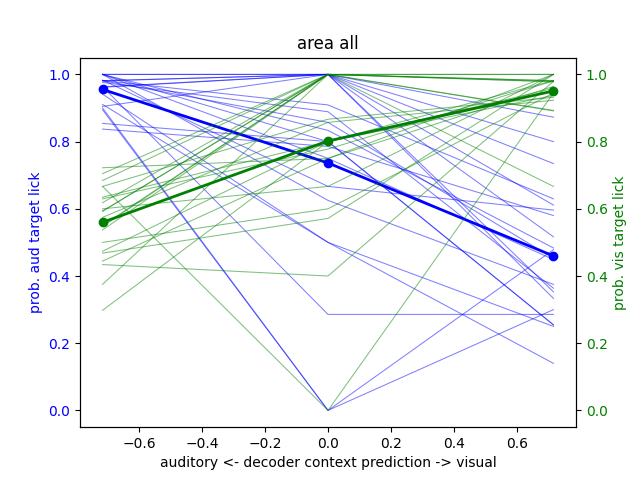

Text(0.5, 1.0, 'area all')

In [39]:
# find probability of response depending on decoder accuracy

aa='all'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
        
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]

#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
    decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0

        
fig,ax1=plt.subplots()
#vis performance plot
color = 'blue'
ax1.set_xlabel('auditory <- decoder context prediction -> visual')
ax1.set_ylabel('prob. aud target lick', color=color)
ax1.plot(xbin_midpoints,aud_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(aud_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
# ax1.set_ylim([0.2,1.1])
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'green'
ax2.set_ylabel('prob. vis target lick', color=color)
ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax1.set_title('area '+aa)

In [17]:
# block_label[incl_trials]
sel_session

5

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


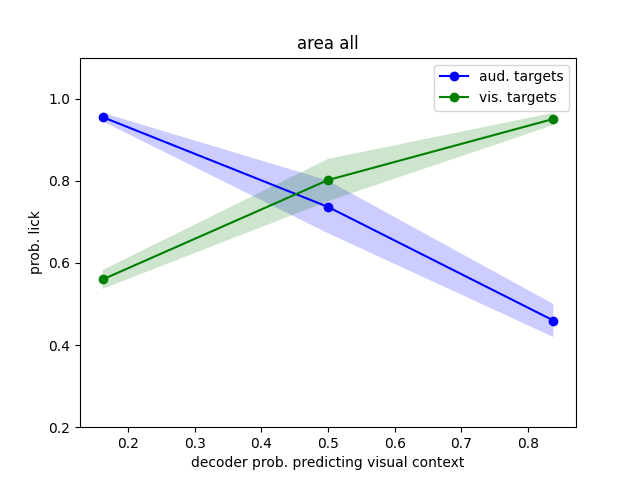

Text(0.5, 1.0, 'area all')

In [40]:
# find probability of response depending on decoder accuracy
# PLOT WITH STDERROR!

aa='all'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbins = np.asarray([-0.01,1/3,2/3,1.01])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=xbins[bb])&(decoder_pred_shuffle<xbins[bb+1])
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
            vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=xbins[bb])&(decoder_pred_shuffle<xbins[bb+1])
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
            aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('decoder prob. predicting visual context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


# y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
# err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='b')

# y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
# err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)

In [ ]:
len(svc_results)

<IPython.core.display.Javascript object>


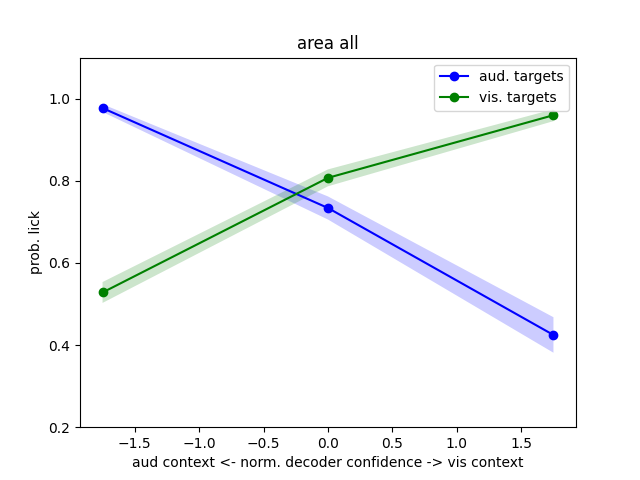

Text(0.5, 1.0, 'area all')

In [41]:
# find probability of response depending on decoder accuracy
# USE DECISION FUNCTION!

aa='all'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-3,-1/2,1/2,3])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])



xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

#     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])/np.nanstd(dec_func[sel_session][aa][p][incl_trials])
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):
        
        min_edge=xbins[bb]
        max_edge=xbins[bb+1]
        if bb==0:
            min_edge=-1000
        elif bb==len(xbins[:-1])-1:
            max_edge=1000
            
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
            vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
            aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


# y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
# err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='b')

# y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
# err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)

In [ ]:
# trial_info[0]['vis_target_response']

<IPython.core.display.Javascript object>


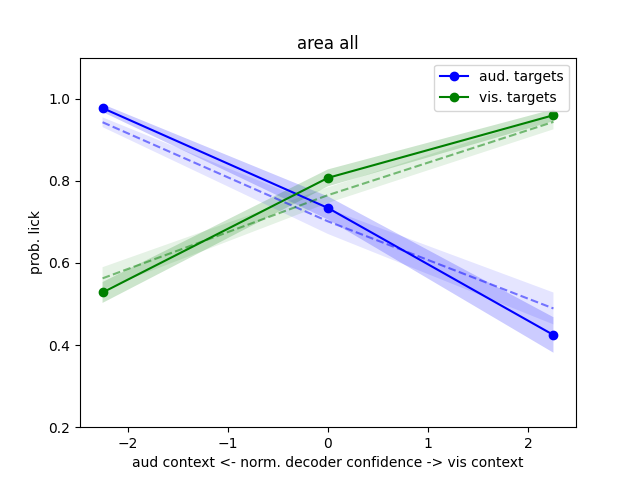

Text(0.5, 1.0, 'area all')

In [42]:
## same but with shuffle correction
## shuffle within blocks


# find probability of response depending on decoder accuracy
# USE DECISION FUNCTION!

aa='all'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-4,-1/2,1/2,4])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])



xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

#     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])/np.nanstd(dec_func[sel_session][aa][p][incl_trials])
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    
    decoder_pred_shuffle_by_block=np.zeros(len(decoder_pred))
    decoder_pred_shuffle_by_block[:]=np.nan
    block_num_incl=trial_info[sel_session]['block_number'][incl_trials]
    for bl in np.unique(block_num_incl):
        blockind=block_num_incl==bl
        decoder_pred_shuffle_by_block[blockind]=np.random.choice(decoder_pred[blockind],np.sum(blockind),replace=False)
    
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):
        
        min_edge=xbins[bb]
        max_edge=xbins[bb+1]
        if bb==0:
            min_edge=-1000
        elif bb==len(xbins[:-1])-1:
            max_edge=1000
            
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
#         if np.isnan(vis_resp_prob[bb,sel_session]):
#             vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
#         if np.isnan(aud_resp_prob[bb,sel_session]):
#             aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle_by_block>=min_edge)&(decoder_pred_shuffle_by_block<max_edge)
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
#         if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
#             vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle_by_block>=min_edge)&(decoder_pred_shuffle_by_block<max_edge)
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
#         if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
#             aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='b')

y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)




In [ ]:
# trial_info[20]['block_number'][incl_trials]
# trial_info[sel_session]['autoreward']
# decoder_pred_shuffle_by_block

In [ ]:
sel_session

In [ ]:
# decoder_pred_shuffle_by_block

<IPython.core.display.Javascript object>


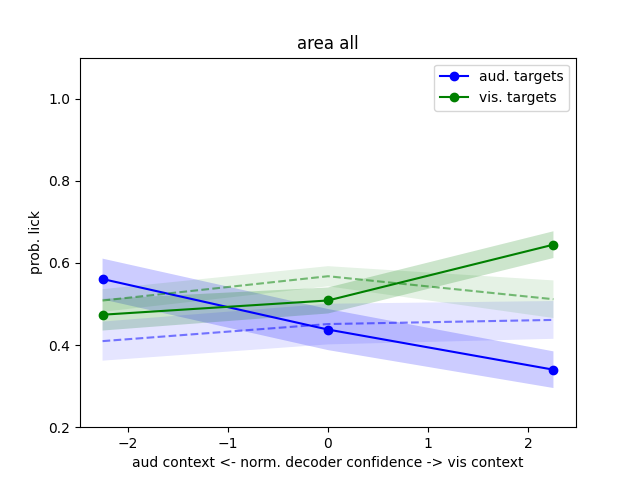

Text(0.5, 1.0, 'area all')

In [43]:
### separately correlate prob. lick and decoder confidence


aa='all'
p='block_ids'
block_type=['vis1','sound1']

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-4,-1/2,1/2,4])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])
# xbins = np.asarray([-2,0,2])
# xbins = np.asarray([0,1/2,1,4])

xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    for block in block_type:
        incl_trials = (~trial_info[sel_session]['autoreward'])&(trial_info[sel_session]['trialstimRewarded']==block)

        # vis_resp_prob=np.zeros(len(xbin_midpoints))
        # aud_resp_prob=np.zeros(len(xbin_midpoints))

    #     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
        
        decoder_pred=((dec_func[sel_session][aa][p][incl_trials]-
                       np.nanmean(dec_func[sel_session][aa][p][incl_trials]))
                      /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))

#         decoder_pred=((dec_func[sel_session][aa][p][incl_trials])
#                       /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))
#         if block=='sound1':
#         decoder_pred=np.abs(decoder_pred)
        decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

#         decoder_pred_shuffle_by_block=np.zeros(len(decoder_pred))
#         decoder_pred_shuffle_by_block[:]=np.nan
#         block_num_incl=trial_info[sel_session]['block_number'][incl_trials]
#         for bb in np.unique(block_num_incl):
#             blockind=block_num_incl==bb
#             decoder_pred_shuffle_by_block[blockind]=np.random.choice(decoder_pred[blockind],np.sum(blockind),replace=False)

        block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#         stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
        stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
    #     #make sound blocks a negative prediction
    #     for xx in range(0,len(decoder_pred)):
    #         if 'sound' in block_label[xx]:
    #             decoder_pred[xx]=-decoder_pred[xx]
    #     decoder_pred = (decoder_pred*2)-1

        vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
        aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

        for bb in range(0,len(xbins[:-1])):

            min_edge=xbins[bb]
            max_edge=xbins[bb+1]
            if bb==0:
                min_edge=-1000
            elif bb==len(xbins[:-1])-1:
                max_edge=1000
            
            if block=='sound1':
                vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
                vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        #         if np.isnan(vis_resp_prob[bb,sel_session]):
        #             vis_resp_prob[bb,sel_session]=0
                #shuffle
                vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
                vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        #         if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
        #             vis_resp_prob_shuffle[bb,sel_session]=0
            
            elif block=='vis1':
                aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
                aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        #         if np.isnan(aud_resp_prob[bb,sel_session]):
        #             aud_resp_prob[bb,sel_session]=0
                #shuffle
                aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
                aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        #         if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
        #             aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='b')

y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)







<IPython.core.display.Javascript object>


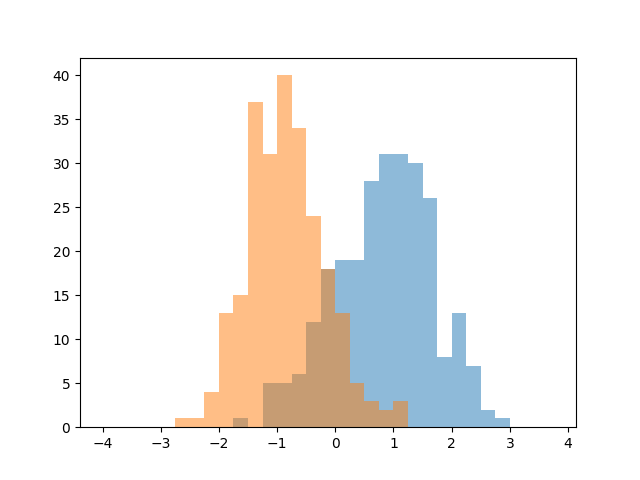

In [44]:
sel_session=15
fig,ax=plt.subplots()
bins=np.arange(-4,4,0.25)

for block in ['vis1','sound1']:
    incl_trials = (~trial_info[sel_session]['autoreward'])&(trial_info[sel_session]['trialstimRewarded']==block)
#     decoder_pred=((dec_func[sel_session][aa][p][incl_trials]-
#                        np.nanmean(dec_func[sel_session][aa][p][incl_trials]))
#                       /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])


    ax.hist(decoder_pred,bins=bins,alpha=0.5)

<IPython.core.display.Javascript object>


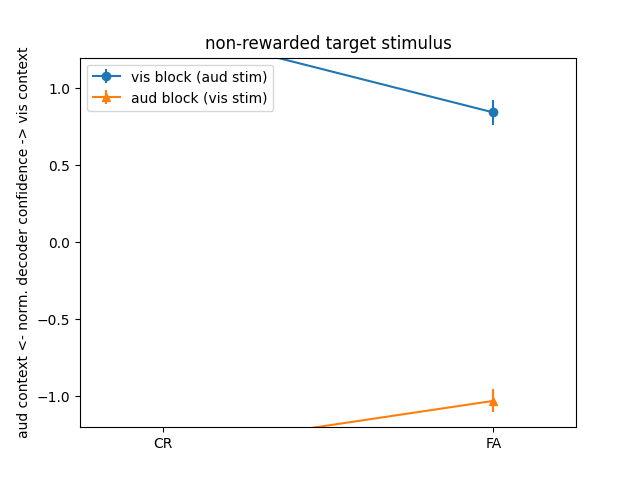

In [70]:
### plot avg decoder confidence for CR vs. FA for non-rewarded target

aa='all'
p='block_ids'
block_type=['vis1','sound1']

vis_block_cr_conf=np.zeros(len(sessions))
vis_block_cr_conf[:]=np.nan
vis_block_fa_conf=np.zeros(len(sessions))
vis_block_fa_conf[:]=np.nan
aud_block_cr_conf=np.zeros(len(sessions))
aud_block_cr_conf[:]=np.nan
aud_block_fa_conf=np.zeros(len(sessions))
aud_block_fa_conf[:]=np.nan

#for each session
for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue

    for block in block_type:
        if block=='vis1':
            other_target='aud'
            other_stim = 'sound1'
        elif block=='sound1':
            other_target='vis'
            other_stim='vis1'
        
        
        if 'trialOptoVoltage' in sessions[sel_session].trials.columns:
            temp_trials = sessions[sel_session].trials.query('trialOptoVoltage.isnull()')
        else:
            temp_trials = sessions[sel_session].trials
        
        cr_trials = ((temp_trials['trialstimRewarded'] == block)&
                     (temp_trials['vis_autoreward_trials'] == False)&
                     (temp_trials['aud_autoreward_trials'] == False)&
                     (temp_trials['trialStimID'] == other_stim)&
                     (temp_trials['trial_response'] == False))
                                      
        
        fa_trials = ((temp_trials['trialstimRewarded'] == block)&
                     (temp_trials['vis_autoreward_trials'] == False)&
                     (temp_trials['aud_autoreward_trials'] == False)&
                     (temp_trials['trialStimID'] == other_stim)&
                     (temp_trials['trial_response'] == True))
        
#         cr_trials = temp_trials.query('trialstimRewarded == @block and \
#                                       vis_autoreward_trials == False and \
#                                       aud_autoreward_trials == False and \
#                                       trialStimID == @other_stim and \
#                                       trial_response == False')
        
#         fa_trials = temp_trials.query('trialstimRewarded == @block and \
#                                       vis_autoreward_trials == False and \
#                                       aud_autoreward_trials == False and \
#                                       trialStimID == @other_stim and \
#                                       trial_response == True')
        
        
#         cr_trials = ((~trial_info[sel_session]['autoreward'])&
#                      (trial_info[sel_session]['trialstimRewarded']==block)&
#                      (~trial_info[sel_session][other_target+'_target_response']))
        
#         fa_trials = ((~trial_info[sel_session]['autoreward'])&
#                      (trial_info[sel_session]['trialstimRewarded']==block)&
#                      (trial_info[sel_session][other_target+'_target_response']))
        
#         print('n cr trials = '+str(np.sum(cr_trials)))
#         print('n fa trials = '+str(np.sum(fa_trials)))
        
        
        #get decoder confidence
        decoder_cr_pred=((dec_func[sel_session][aa][p][cr_trials])
                          /np.nanmean(([np.nanstd(dec_func[sel_session][aa][p][cr_trials]),
                            np.nanstd(dec_func[sel_session][aa][p][fa_trials])])))
        
        decoder_fa_pred=((dec_func[sel_session][aa][p][fa_trials])
                          /np.nanmean(([np.nanstd(dec_func[sel_session][aa][p][cr_trials]),
                            np.nanstd(dec_func[sel_session][aa][p][fa_trials])])))
        
    
        
        if block=='vis1':
            vis_block_cr_conf[sel_session]=np.nanmean(decoder_cr_pred)
            vis_block_fa_conf[sel_session]=np.nanmean(decoder_fa_pred)
        elif block=='sound1':
            aud_block_cr_conf[sel_session]=np.nanmean(decoder_cr_pred)
            aud_block_fa_conf[sel_session]=np.nanmean(decoder_fa_pred)



fig,ax=plt.subplots()

ax.errorbar([0,1],[np.nanmean(vis_block_cr_conf),np.nanmean(vis_block_fa_conf)],
           [np.nanstd(vis_block_cr_conf)/np.sqrt(np.sum(~np.isnan(vis_block_cr_conf))),
            np.nanstd(vis_block_fa_conf)/np.sqrt(np.sum(~np.isnan(vis_block_fa_conf)))],marker='o')

ax.errorbar([0,1],[np.nanmean(aud_block_cr_conf),np.nanmean(aud_block_fa_conf)],
           [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
            np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

ax.set_ylim([-1.2,1.2])

ax.set_xticks([0,1])
ax.set_xticklabels(['CR','FA'])
ax.set_xlim(-0.25,1.25)
ax.set_ylabel('aud context <- norm. decoder confidence -> vis context')

ax.set_title('non-rewarded target stimulus')
ax.legend(['vis block (aud stim)','aud block (vis stim)'])



In [75]:
# [np.nanstd(dec_func[sel_session][aa][p][cr_trials]),np.nanstd(dec_func[sel_session][aa][p][fa_trials])]

<IPython.core.display.Javascript object>


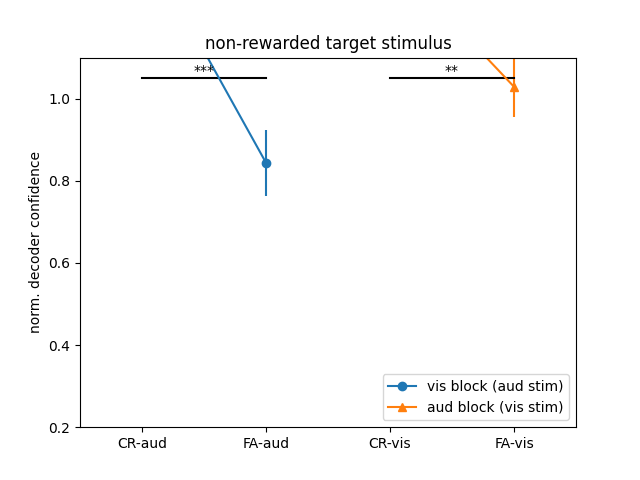

In [76]:
h,vis_p=st.wilcoxon(vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
            vis_block_fa_conf[~np.isnan(vis_block_fa_conf)])
h,aud_p=st.wilcoxon(aud_block_cr_conf[~np.isnan(aud_block_cr_conf)],
            aud_block_fa_conf[~np.isnan(aud_block_fa_conf)])

fig,ax=plt.subplots()

l1=ax.errorbar(np.asarray([0,1]),[np.nanmean(vis_block_cr_conf),np.nanmean(vis_block_fa_conf)],
           [np.nanstd(vis_block_cr_conf)/np.sqrt(np.sum(~np.isnan(vis_block_cr_conf))),
            np.nanstd(vis_block_fa_conf)/np.sqrt(np.sum(~np.isnan(vis_block_fa_conf)))],marker='o')

ax.plot([0,1],[1.05,1.05],'k')

if vis_p<0.001:
    ax.text(0.5,1.05,'***',ha='center',va='bottom')
elif vis_p<0.01:
    ax.text(0.5,1.05,'**',ha='center',va='bottom')
elif vis_p<0.05:
    ax.text(0.5,1.05,'*',ha='center',va='bottom')
elif vis_p>=0.05:
    ax.text(0.5,1.05,'n.s.',ha='center',va='bottom')

l2=ax.errorbar(np.asarray([2,3]),[-np.nanmean(aud_block_cr_conf),-np.nanmean(aud_block_fa_conf)],
           [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
            np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

ax.plot([2,3],[1.05,1.05],'k')

if aud_p<0.001:
    ax.text(2.5,1.05,'***',ha='center',va='bottom')
elif aud_p<0.01:
    ax.text(2.5,1.05,'**',ha='center',va='bottom')
elif aud_p<0.05:
    ax.text(2.5,1.05,'*',ha='center',va='bottom')
elif aud_p>=0.05:
    ax.text(2.5,1.05,'n.s.',ha='center',va='bottom')

ax.set_ylim([0.2,1.1])

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['CR-aud','FA-aud','CR-vis','FA-vis'])
ax.set_xlim(-0.5,3.5)
ax.set_ylabel('norm. decoder confidence')

ax.set_title('non-rewarded target stimulus')
ax.legend([l1[0],l2[0]],['vis block (aud stim)','aud block (vis stim)'],loc='lower right')

In [77]:
st.wilcoxon(vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
            vis_block_fa_conf[~np.isnan(vis_block_fa_conf)])
# st.wilcoxon(aud_block_cr_conf,aud_block_fa_conf,nan_policy='omit')

WilcoxonResult(statistic=10.0, pvalue=2.0503997802734375e-05)

In [78]:
st.wilcoxon(aud_block_cr_conf[~np.isnan(aud_block_cr_conf)],
            aud_block_fa_conf[~np.isnan(aud_block_fa_conf)])

WilcoxonResult(statistic=38.0, pvalue=0.0028514862060546875)

<IPython.core.display.Javascript object>


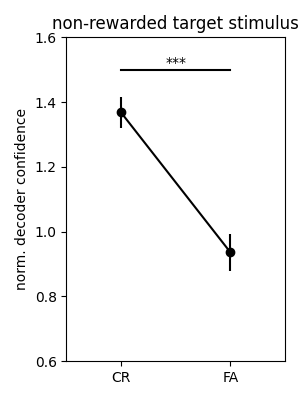

In [82]:
all_block_cr_conf=np.hstack([vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
                           -aud_block_cr_conf[~np.isnan(aud_block_cr_conf)]])

all_block_fa_conf=np.hstack([vis_block_fa_conf[~np.isnan(vis_block_fa_conf)],
                           -aud_block_fa_conf[~np.isnan(aud_block_fa_conf)]])

h,all_p=st.wilcoxon(all_block_cr_conf,all_block_fa_conf)

fig,ax=plt.subplots(figsize=(3,4))

l1=ax.errorbar(np.asarray([0,1]),[np.nanmean(all_block_cr_conf),np.nanmean(all_block_fa_conf)],
           [np.nanstd(all_block_cr_conf)/np.sqrt(np.sum(~np.isnan(all_block_cr_conf))),
            np.nanstd(all_block_fa_conf)/np.sqrt(np.sum(~np.isnan(all_block_fa_conf)))],marker='o',color='k')

sig_line_pos=1.5

ax.plot([0,1],[sig_line_pos,sig_line_pos],'k')

if all_p<0.001:
    ax.text(0.5,sig_line_pos,'***',ha='center',va='bottom')
elif all_p<0.01:
    ax.text(0.5,sig_line_pos,'**',ha='center',va='bottom')
elif all_p<0.05:
    ax.text(0.5,sig_line_pos,'*',ha='center',va='bottom')
elif all_p>=0.05:
    ax.text(0.5,sig_line_pos,'n.s.',ha='center',va='bottom')

# l2=ax.errorbar(np.asarray([2,3]),[-np.nanmean(aud_block_cr_conf),-np.nanmean(aud_block_fa_conf)],
#            [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
#             np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

# ax.plot([2,3],[1.05,1.05],'k')

# if aud_p<0.001:
#     ax.text(2.5,1.05,'***',ha='center',va='bottom')
# elif aud_p<0.01:
#     ax.text(2.5,1.05,'**',ha='center',va='bottom')
# elif aud_p<0.05:
#     ax.text(2.5,1.05,'*',ha='center',va='bottom')
# elif aud_p>=0.05:
#     ax.text(2.5,1.05,'n.s.',ha='center',va='bottom')

ax.set_ylim([0.6,1.6])

ax.set_xticks([0,1])
ax.set_xticklabels(['CR','FA'])
ax.set_xlim(-0.5,1.5)
ax.set_ylabel('norm. decoder confidence')

ax.set_title('non-rewarded target stimulus')
# ax.legend([l1[0],l2[0]],['vis block (aud stim)','aud block (vis stim)'],loc='lower right')
fig.tight_layout()

In [84]:
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-08-24-DR-poster-plots-lake-conf\decoder_perf_CR_vs_FA.pdf"
fig.savefig(savepath, dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None,
           )

In [ ]:
np.sum(~np.isnan(vis_block_cr_conf))

In [ ]:
aud_block_fa_conf

In [ ]:
#comp within aud targets
st.wilcoxon(aud_resp_prob[0],aud_resp_prob[2],nan_policy='omit')

In [ ]:
#comp within vis targets
st.wilcoxon(vis_resp_prob[0],vis_resp_prob[2],nan_policy='omit')

In [ ]:
#comp 1st timepoint
st.ranksums(aud_resp_prob[0],vis_resp_prob[0],nan_policy='omit')

In [ ]:
#comp 2nd timepoint
st.ranksums(aud_resp_prob[1],vis_resp_prob[1],nan_policy='omit')

In [ ]:
#comp 3rd timepoint
st.ranksums(aud_resp_prob[2],vis_resp_prob[2],nan_policy='omit')

In [ ]:
#shuffle!
# find probability of response depending on decoder accuracy

aa='CP'
p='block_ids'

# xbins=np.arange(-1,1.1,0.66)
xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p],axis=1)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label']
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label']
    stim_label=trial_info[sel_session]['trialStimID']

#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
    decoder_pred = (decoder_pred*2)-1
    
    decoder_pred = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

    vis_target_response=trial_info[sel_session]['vis_target_response']
    aud_target_response=trial_info[sel_session]['aud_target_response']
    
    vis_target=np.where(trial_info[sel_session]['vis_target'])[0]
    aud_target=np.where(trial_info[sel_session]['aud_target'])[0]

    for bb in range(0,len(xbins[:-1])):

#         vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
#         vis_resp_prob[bb,sel_session]=np.nanmean(
#             vis_target_response[np.random.choice(vis_target,np.sum(vis_trial_idx),replace=False)])
#         if np.isnan(vis_resp_prob[bb,sel_session]):
#             vis_resp_prob[bb,sel_session]=0

#         aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
#         aud_resp_prob[bb,sel_session]=np.nanmean(
#             aud_target_response[np.random.choice(aud_target,np.sum(aud_trial_idx),replace=False)])
#         if np.isnan(aud_resp_prob[bb,sel_session]):
#             aud_resp_prob[bb,sel_session]=0

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0

        
fig,ax1=plt.subplots()
#vis performance plot
color = 'blue'
ax1.set_xlabel('auditory <- decoder context prediction -> visual')
ax1.set_ylabel('prob. aud target lick', color=color)
ax1.plot(xbin_midpoints,aud_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(aud_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
ax1.set_ylim([0.2,1.1])
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'green'
ax2.set_ylabel('prob. vis target lick', color=color)
ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax1.set_title('area '+aa+' - shuffled')

In [ ]:
predict_perf[sel_session][aa][p].shape

In [ ]:
trial_info[sel_session]['vis_target_response'].shape

In [ ]:
# true_label
# decoder_pred

In [ ]:
decoder_acc_session_mean

## decoding across areas

In [66]:
# loop through areas

area_block_decoding={}

for aa in unique_areas:
    
    if aa=='all':
        continue
    # compile avg prestim decoding per area x session
    area_block_decoding[aa]=np.nanmean(np.vstack([decoder_acc_session_mean[aa]['block_ids']['vis1'][0],
                                                  decoder_acc_session_mean[aa]['block_ids']['sound1'][0]]),0)
                                            
area_block_decoding=pd.DataFrame(area_block_decoding)
area_block_decoding

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41520\3901614083.py:10: RuntimeWarning: Mean of empty slice
  area_block_decoding[aa]=np.nanmean(np.vstack([decoder_acc_session_mean[aa]['block_ids']['vis1'][0],


ACB       AId       APN      AUDp     AUDpo       CA1  \
0        NaN       NaN       NaN       NaN  0.689866  0.700518  0.674555   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN  0.603805   
3        NaN  0.565828  0.731518       NaN       NaN       NaN  0.581040   
4        NaN  0.588127  0.673510       NaN       NaN  0.658437       NaN   
5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7        NaN       NaN       NaN  0.701003       NaN       NaN       NaN   
8        NaN       NaN       NaN       NaN       NaN       NaN  0.654649   
9        NaN       NaN       NaN       NaN       NaN       NaN  0.667876   
10       NaN       NaN       NaN       NaN       NaN       NaN  0.634074   
11  0.759764       NaN       NaN       NaN       NaN       NaN  0.654671   
12       NaN       NaN       NaN       NaN       NaN       NaN  0.642742   
13       NaN       NaN       NaN       NaN       NaN       NaN  0.677180   
14       NaN       NaN       NaN       NaN       NaN       NaN  0.540553   
15       NaN       NaN       NaN       NaN       NaN       NaN  0.619979   
16       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
17       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
18       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
19       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
20       NaN       NaN       NaN       NaN       NaN       NaN  0.616959   
21       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         CA3        CL        CP  ...     VISal     VISam      VISl     VISli  \
0        NaN       NaN  0.693326  ...       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
2        NaN       NaN  0.638887  ...       NaN  0.653897       NaN  0.575851   
3        NaN       NaN  0.624488  ...       NaN       NaN       NaN  0.594330   
4        NaN       NaN  0.665291  ...       NaN       NaN       NaN       NaN   
5        NaN       NaN  0.630069  ...       NaN  0.620750       NaN       NaN   
6        NaN       NaN       NaN  ...       NaN       NaN  0.553920       NaN   
7        NaN       NaN  0.647152  ...       NaN       NaN  0.660885       NaN   
8        NaN       NaN  0.662663  ...       NaN       NaN  0.646696       NaN   
9        NaN       NaN  0.773014  ...       NaN       NaN  0.686377       NaN   
10       NaN       NaN       NaN  ...       NaN       NaN  0.733965       NaN   
11       NaN       NaN  0.766932  ...       NaN       NaN       NaN       NaN   
12       NaN       NaN  0.751857  ...       NaN  0.651860       NaN       NaN   
13       NaN       NaN  0.805540  ...       NaN       NaN       NaN       NaN   
14  0.609646       NaN       NaN  ...       NaN       NaN       NaN       NaN   
15       NaN  0.732261       NaN  ...  0.714084       NaN       NaN       NaN   
16  0.570869       NaN  0.663859  ...       NaN       NaN       NaN       NaN   
17  0.583421       NaN  0.779163  ...       NaN       NaN       NaN       NaN   
18  0.666358       NaN  0.722788  ...       NaN       NaN       NaN       NaN   
19       NaN       NaN  0.787432  ...       NaN       NaN       NaN       NaN   
20       NaN       NaN  0.655320  ...       NaN       NaN  0.619237       NaN   
21       NaN       NaN  0.688894  ...       NaN       NaN       NaN       NaN   

        VISp     VISpm    VISpor     VISrl       VPL       VPM  
0        NaN  0.678607       NaN       NaN       NaN  0.712668  
1   0.603092       NaN       NaN       NaN       NaN       NaN  
2   0.581326       NaN       NaN       NaN       NaN       NaN  
3   0.597724       NaN       NaN       NaN       NaN       NaN  
4   0.619305       NaN       NaN       NaN       NaN       NaN  
5   0.641204    

In [67]:
# decoder_acc_session_mean[aa]['block_ids']['sound1'][0]

In [68]:
area_block_decoding.columns[(area_block_decoding.isna().sum()<=(len(svc_results)-5))]

Index(['CA1', 'CP', 'DG', 'LP', 'MOp', 'MOs', 'ProS', 'RSPagl', 'SGN',
       'SSp-bfd', 'SUB', 'VISl', 'VISp'],
      dtype='object')

<IPython.core.display.Javascript object>


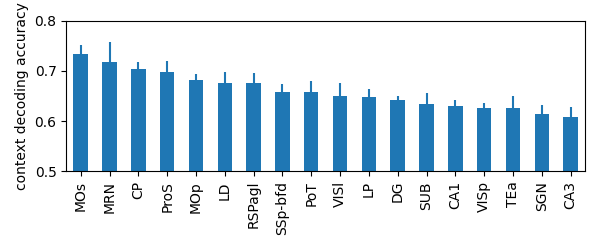

In [85]:
min_n_recs=4

area_means=area_block_decoding.mean()[(area_block_decoding.isna().sum()<=(len(svc_results)-min_n_recs))].sort_values(ascending=False)
area_stds=area_block_decoding.sem()[(area_block_decoding.isna().sum()<=(len(svc_results)-min_n_recs))].loc[area_means.index]



fig,ax=plt.subplots(figsize=(6,2.5))
ax=area_means.plot.bar()

ax.errorbar(area_means.index,area_means.values,area_stds.values,linestyle='')

ax.set_ylim([0.5,0.8])
ax.set_ylabel('context decoding accuracy')

fig.tight_layout()

In [86]:
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-08-24-DR-poster-plots-lake-conf\decoding_across_areas.pdf"
fig.savefig(savepath, dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None,
           )

## plot decoder performance by block number

In [ ]:

for aa in unique_areas:

    #aa='MOs'
    p='block_ids'

    xbins = np.asarray([1,2,3,4,5,6])

    decoder_by_block_visfirst=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_visfirst[:]=np.nan

    decoder_by_block_visfirst_shuffle=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_visfirst_shuffle[:]=np.nan

    decoder_by_block_audfirst=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_audfirst[:]=np.nan

    decoder_by_block_audfirst_shuffle=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_audfirst_shuffle[:]=np.nan


    for sel_session in range(0,len(svc_results)): #sessions:

        if aa not in predict_perf[sel_session].keys():
            continue

        incl_trials = ~trial_info[sel_session]['autoreward']

#         decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
        decoder_pred=dec_func[sel_session][aa][p][incl_trials]/np.std(dec_func[sel_session][aa][p][incl_trials])
        decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

        block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
        stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]

        block_num=trial_info[sel_session]['block_number'][incl_trials]
        block_num_shuffle=np.random.choice(block_num,len(block_num),replace=False)


        for ib,bb in enumerate(xbins):

            if block_label[0]=='vis1':
                trial_idx=block_num==bb
                decoder_by_block_visfirst[ib,sel_session]=np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block[ib,sel_session]):
        #             decoder_by_block[ib,sel_session]=0

                trial_idx=block_num_shuffle==bb
                decoder_by_block_visfirst_shuffle[ib,sel_session]=np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
        #             decoder_by_block_shuffle[ib,sel_session]=0

            elif block_label[0]=='sound1':
                trial_idx=block_num==bb
#                 decoder_by_block_audfirst[ib,sel_session]=np.mean(decoder_pred[trial_idx])
#         #         if np.isnan(decoder_by_block[ib,sel_session]):
#         #             decoder_by_block[ib,sel_session]=0

#                 trial_idx=block_num_shuffle==bb
#                 decoder_by_block_audfirst_shuffle[ib,sel_session]=np.mean(decoder_pred[trial_idx])
#         #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
#         #             decoder_by_block_shuffle[ib,sel_session]=0

                decoder_by_block_visfirst[ib,sel_session]=-np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block[ib,sel_session]):
        #             decoder_by_block[ib,sel_session]=0

                trial_idx=block_num_shuffle==bb
                decoder_by_block_visfirst_shuffle[ib,sel_session]=-np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
        #             decoder_by_block_shuffle[ib,sel_session]=0



    fig,ax=plt.subplots()

    #vis performance plot

    ax.set_xlabel('block number')
#     ax.set_ylabel('prob. visual context')
    ax.set_ylabel('decoder confidence')

#     #true decoder accuracy
#     y1=np.nanmean(decoder_by_block_audfirst,axis=1)
#     err1=np.nanstd(decoder_by_block_audfirst,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_audfirst[0,:])))
#     l1aud=ax.plot(xbins, y1,'b',linestyle='-',marker='o')
#     plt.fill_between(xbins, y1-err1, y1+err1,
#         alpha=0.2, edgecolor=None, facecolor='b')

    y1=np.nanmean(decoder_by_block_visfirst,axis=1)
    err1=np.nanstd(decoder_by_block_visfirst,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_visfirst[0,:])))
    l1vis=ax.plot(xbins, y1,'g',linestyle='-',marker='o')
    plt.fill_between(xbins, y1-err1, y1+err1,
        alpha=0.2, edgecolor=None, facecolor='g')


#     #shuffle
#     y0=np.nanmean(decoder_by_block_audfirst_shuffle,axis=1)
#     err0=np.nanstd(decoder_by_block_audfirst_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_audfirst_shuffle[0,:])))
#     l0=ax.plot(xbins, y0,'b',linestyle='--',alpha=0.5)
#     plt.fill_between(xbins, y0-err0, y0+err0,
#         alpha=0.1, edgecolor=None, facecolor='b')

    y0=np.nanmean(decoder_by_block_visfirst_shuffle,axis=1)
    err0=np.nanstd(decoder_by_block_visfirst_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_visfirst_shuffle[0,:])))
    l0=ax.plot(xbins, y0,'g',linestyle='--',alpha=0.5)
    plt.fill_between(xbins, y0-err0, y0+err0,
        alpha=0.1, edgecolor=None, facecolor='g')

#     ax.legend(['aud block first','vis block first'])
    ax.set_ylim([-1,1])
    ax.set_title('area '+aa)
    
    fig.tight_layout()
    
#     figpath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-04-17-DR-decoding-by_block_accuracy"
#     figname=aa+'_by_block_context_decoding.png'
#     figname=figname.replace('/','-')
#     plt.savefig(os.path.join(figpath,figname), dpi=600, facecolor='w', edgecolor='w',
#                 orientation='portrait', format='png',
#                 transparent=True, bbox_inches='tight', pad_inches=0.1,
#                 metadata=None)

In [ ]:
#next: try plotting prob(vis target lick) and prob(aud target lick)



## performance vs. trials since last bit of information

In [39]:
#use decoder confidence?

sel_session=0

#svc_results[sel_session][predict_var][area][timepoint][repeat]

norm_dec_func=svc_results[sel_session]['block_ids']['MOs'][0][0]['decision_function']/np.nanstd(
    svc_results[sel_session]['block_ids']['MOs'][0][0]['decision_function'])

rewarded_trials=trial_info[sel_session]['trial_rewarded']
response_trials=trial_info[sel_session]['trial_response']

vis_target_response=trial_info[sel_session]['vis_target_response']
aud_target_response=trial_info[sel_session]['aud_target_response']

In [40]:
svc_results[sel_session]['block_ids']['MOs'].keys()

dict_keys(['n_units', 0])

<IPython.core.display.Javascript object>


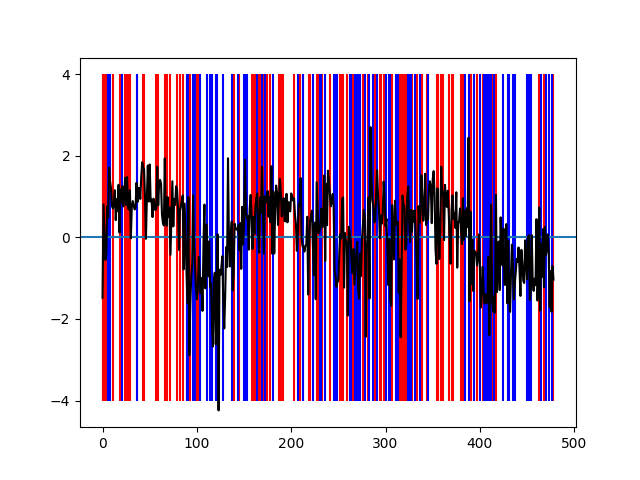

In [41]:
fig,ax=plt.subplots()
ax.axhline(0)
ax.plot(norm_dec_func,'k')

# ax.vlines(np.where(response_trials)[0],ymin=-4,ymax=4,color='red')
# ax.vlines(np.where(rewarded_trials)[0],ymin=-4,ymax=4,color='blue')

ax.vlines(np.where(vis_target_response)[0],ymin=-4,ymax=4,color='red')
ax.vlines(np.where(aud_target_response)[0],ymin=-4,ymax=4,color='blue')

In [ ]:
#first try for a single session?

#invert decoder confidence for auditory blocks

#find all trials where the last reward was on the last trial

#iterate through, 2, 3, 4, 5 trials ago etc.

#also do this for last unrewarded response

In [ ]:
# trials since transition?

In [ ]:
# does information affect decoder confidence more if it is already far from zero?

## before and after bit of information

In [ ]:
#use decoder confidence?

## feature importance

<IPython.core.display.Javascript object>


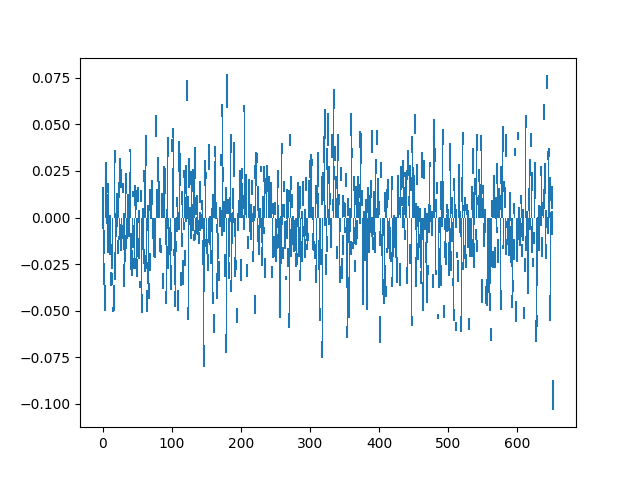

<ErrorbarContainer object of 3 artists>

In [73]:
n_reps=len(np.vstack(svc_results[0]['block_ids']['all'][0][0]['coefs']))
coef_mean=np.mean(np.vstack(svc_results[0]['block_ids']['all'][0][0]['coefs']),axis=0)
coef_std=np.std(np.vstack(svc_results[0]['block_ids']['all'][0][0]['coefs']),axis=0)/np.sqrt(n_reps)

uids=svc_results[0]['block_ids']['all'][0][0]['unit_sel_idx']

xvals=np.arange(0,len(coef_mean))

fig,ax=plt.subplots()
ax.bar(xvals,coef_mean)
ax.errorbar(xvals,coef_mean,coef_std,linestyle='')

In [110]:
# sessions[0].good_units[uids]
uids

array([2208151110004, 2208151110002, 2208151110006, 2208151110012,
       2208151110014, 2208151110011, 2208151110015, 2208151110453,
       2208151110017, 2208151110019, 2208151110021, 2208151110022,
       2208151110025, 2208151110029, 2208151110030, 2208151110032,
       2208151110033, 2208151110035, 2208151110038, 2208151110454,
       2208151110042, 2208151110047, 2208151110053, 2208151110058,
       2208151110061, 2208151110054, 2208151110063, 2208151110071,
       2208151110066, 2208151110455, 2208151110075, 2208151110083,
       2208151110086, 2208151110094, 2208151110096, 2208151110102,
       2208151110106, 2208151110105, 2208151110107, 2208151110111,
       2208151110114, 2208151110116, 2208151110118, 2208151110458,
       2208151110124, 2208151110121, 2208151110126, 2208151110127,
       2208151110128, 2208151110137, 2208151110140, 2208151110141,
       2208151110151, 2208151110144, 2208151110145, 2208151110146,
       2208151110153, 2208151110467, 2208151110154, 2208151110

In [114]:
sessions[0].good_units.loc[uids]

quality  cluster_id probe  firing_rate  presence_ratio  \
id                                                                     
2208151110004    good           4     A    19.871350            0.99   
2208151110002    good           2     A     4.481252            0.99   
2208151110006    good           6     A    12.692753            0.99   
2208151110012    good          12     A    18.970627            0.99   
2208151110014    good          14     A     9.237390            0.99   
...               ...         ...   ...          ...             ...   
2208151160439    good         439     F    11.047175            0.99   
2208151160442    good         442     F     2.272084            0.99   
2208151160443    good         443     F    36.168340            0.99   
2208151160445    good         445     F     8.831207            0.99   
2208151160449    good         449     F     4.364638            0.99   

               isi_viol  amplitude_cutoff  isolation_distance   l_ratio  \
id                                                                        
2208151110004  0.049522          0.022552           37.552305  0.128942   
2208151110002  0.053188          0.028146            9.644711  2.208028   
2208151110006  0.025500          0.037872           28.045546  0.376475   
2208151110012  0.050457          0.032922           35.733932  0.134704   
2208151110014  0.061624          0.025082           64.905296  0.130465   
...                 ...               ...                 ...       ...   
2208151160439  0.035681          0.012408           32.232810  0.286242   
2208151160442  0.334226          0.010561           49.006266  0.005357   
2208151160443  0.002827          0.001311          141.786831  0.001938   
2208151160445  0.005268          0.000172          134.180611  0.005746   
2208151160449  0.181161          0.075601           70.730629  0.013520   

                d_prime  ...    area  AP_coord  DV_coord  ML_coord  \
id                       ...                                         
2208151110004  3.578176  ...     VPM     280.0     188.0     174.0   
2208151110002  2.251783  ...     VPM     280.0     188.0     173.0   
2208151110006  3.028024  ...     VPM     280.0     188.0     173.0   
2208151110012  3.578971  ...     VPM     280.0     186.0     174.0   
2208151110014  4.600663  ...     VPM     280.0     186.0     174.0   
...                 ...  ...     ...       ...       ...       ...   
2208151160439  2.405390  ...  MOs2/3     136.0      78.0     156.0   
2208151160442  2.917428  ...  MOs2/3     136.0      75.0     156.0   
2208151160443  6.269814  ...  MOs2/3     136.0      75.0     156.0   
2208151160445  6.453735  ...  MOs2/3     136.0      75.0     156.0   
2208151160449  3.733677  ...  MOs2/3     136.0      74.0     156.0   

               area_short block_diff_pre_sig  block_diff_stim_sig  \
id                                                                  
2208151110004         VPM              False                False   
2208151110002         VPM               True                 True   
2208151110006         VPM              False                False   
2208151110012         VPM               True                 True   
2208151110014         VPM              False                False   
...                   ...                ...                  ...   
2208151160439         MOs               True                 True   
2208151160442         MOs              False                False   
2208151160443         MOs              False                False   
2208151160445         MOs              False                False   
2208151160449         MOs               True                 True   

               block_diff_pre  block_diff_stim  decoder_coef_mean  
id                                                                 
2208151110004       -0.125007        -0.102053           0.005070  
2208151110002       -0.463768        -0.454474          -0.030512  
2208151110006       

In [74]:
coef_sort_inds=np.argsort(coef_mean)

<IPython.core.display.Javascript object>


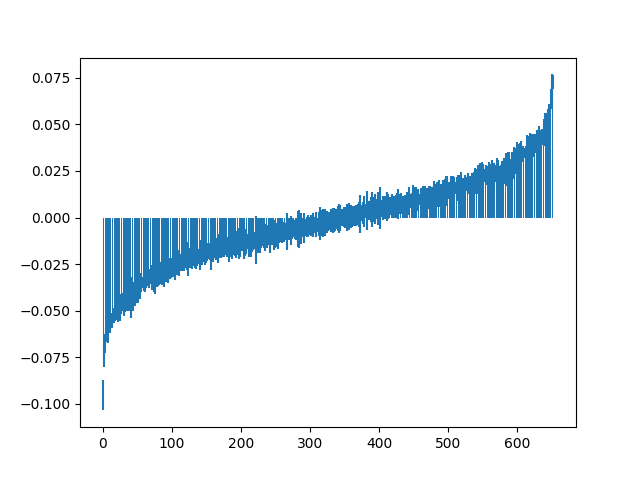

<ErrorbarContainer object of 3 artists>

In [75]:
fig,ax=plt.subplots()
ax.bar(xvals,coef_mean[coef_sort_inds])
ax.errorbar(xvals,coef_mean[coef_sort_inds],coef_std[coef_sort_inds],linestyle='')

In [76]:
MOs_units=sessions[0].good_units.query('area.str.contains("MOs")')
MOs_units.columns

Index(['quality', 'cluster_id', 'probe', 'firing_rate', 'presence_ratio',
       'isi_viol', 'amplitude_cutoff', 'isolation_distance', 'l_ratio',
       'd_prime', 'nn_hit_rate', 'nn_miss_rate', 'silhouette_score',
       'max_drift', 'cumulative_drift', 'epoch_name', 'peak_channel', 'snr',
       'duration', 'halfwidth', 'PT_ratio', 'repolarization_slope',
       'recovery_slope', 'amplitude', 'spread', 'velocity_above',
       'velocity_below', 'area', 'AP_coord', 'DV_coord', 'ML_coord',
       'area_short', 'block_diff_pre_sig', 'block_diff_stim_sig',
       'block_diff_pre', 'block_diff_stim'],
      dtype='object')

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<IPython.core.display.Javascript object>


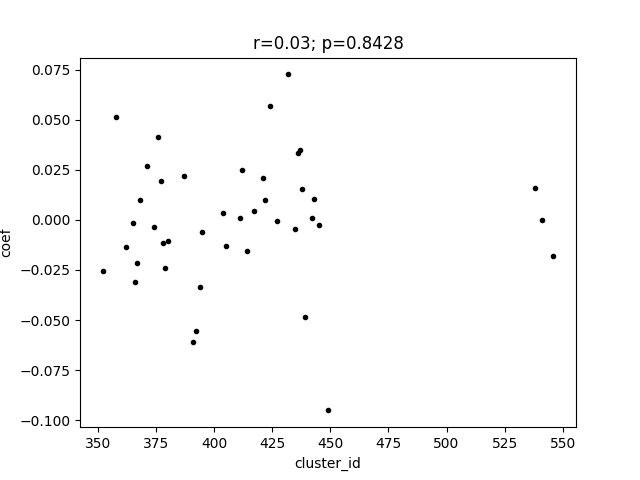

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<IPython.core.display.Javascript object>


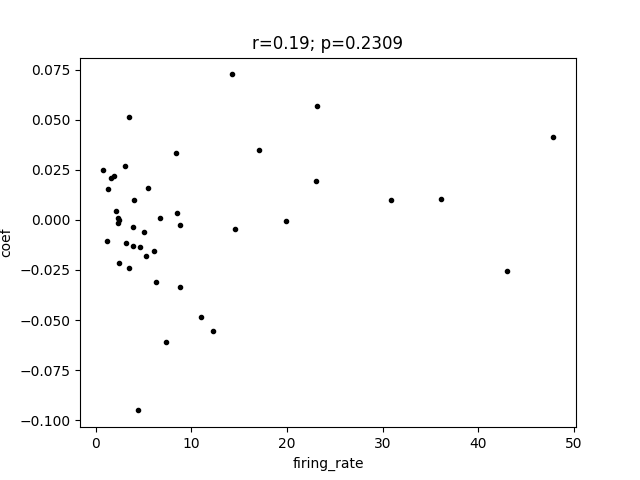

<IPython.core.display.Javascript object>


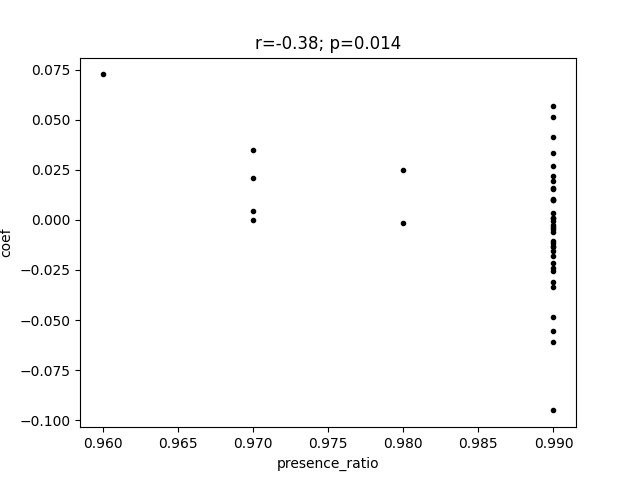

<IPython.core.display.Javascript object>


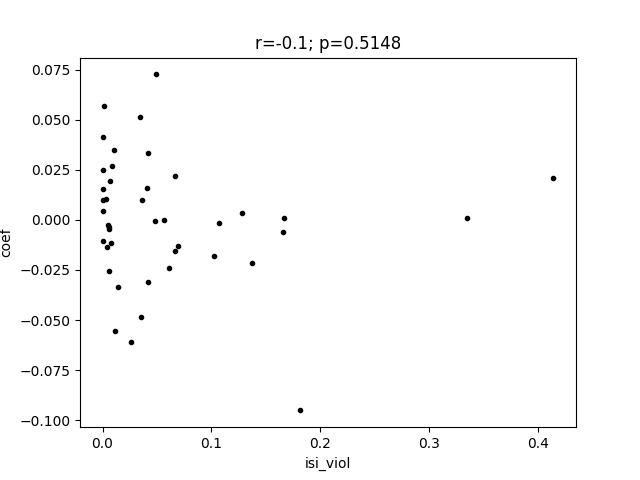

<IPython.core.display.Javascript object>


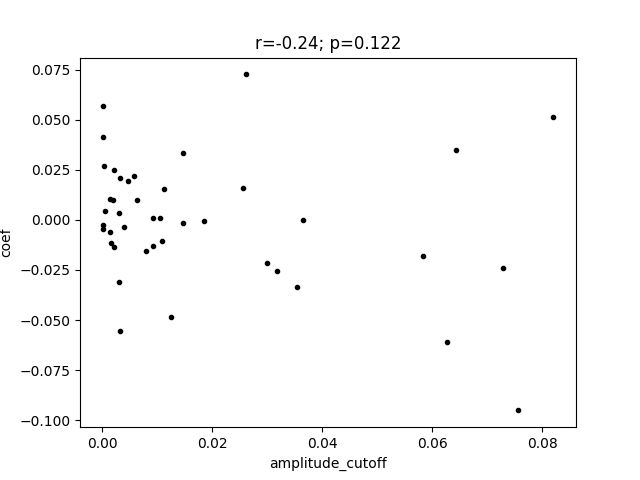

<IPython.core.display.Javascript object>


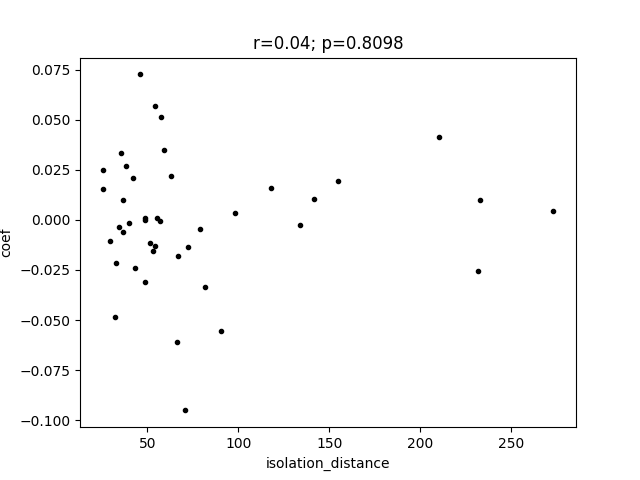

<IPython.core.display.Javascript object>


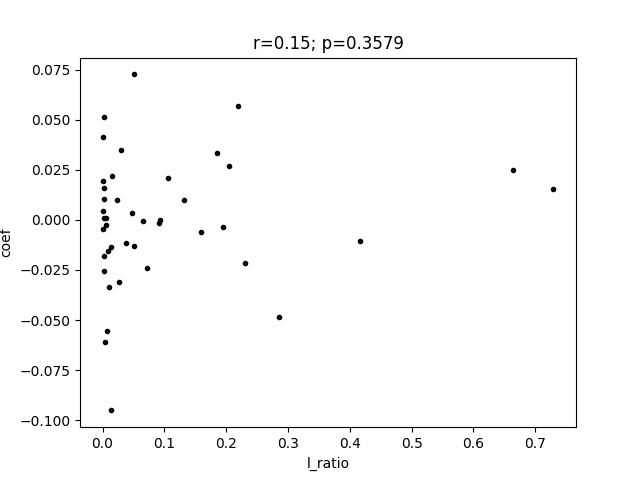

<IPython.core.display.Javascript object>


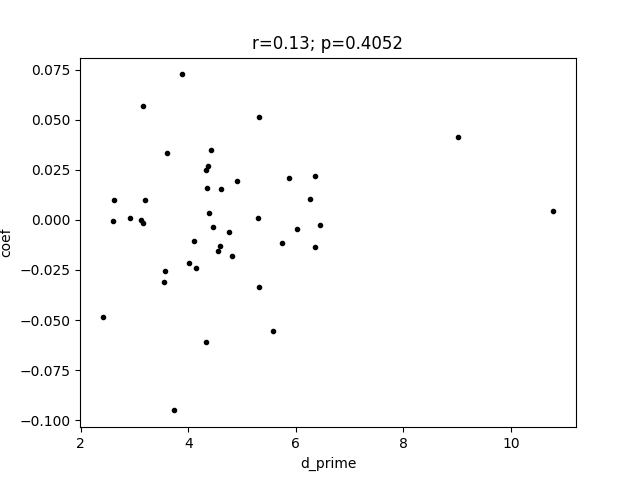

<IPython.core.display.Javascript object>


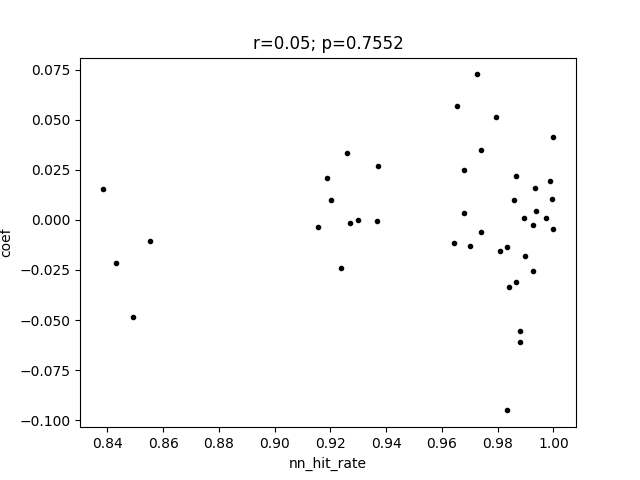

<IPython.core.display.Javascript object>


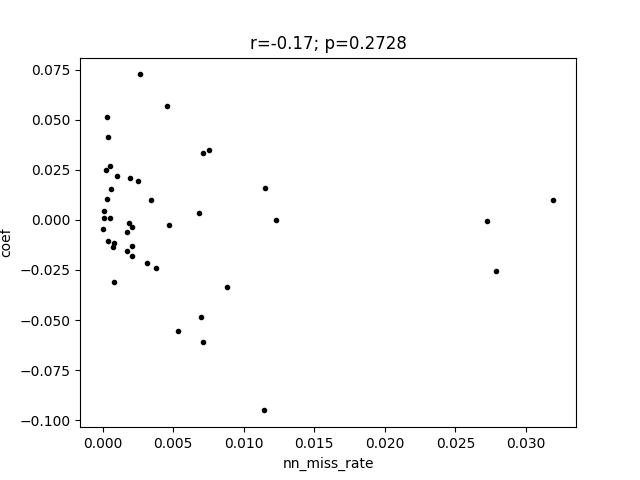

<IPython.core.display.Javascript object>


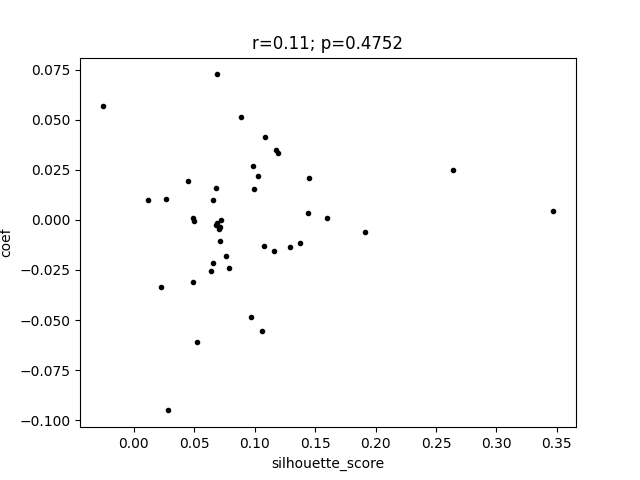

<IPython.core.display.Javascript object>


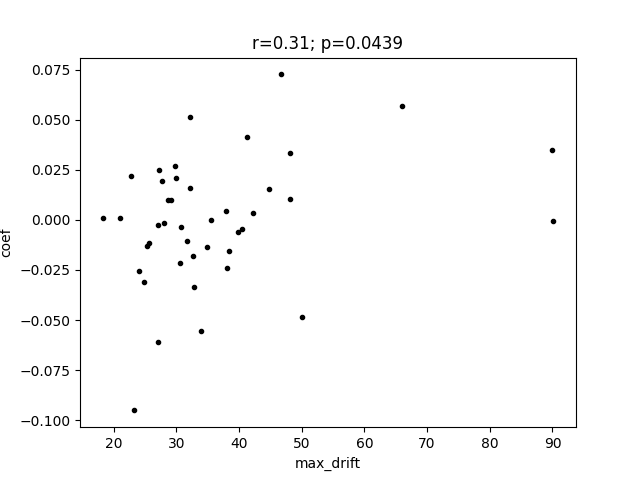

<IPython.core.display.Javascript object>


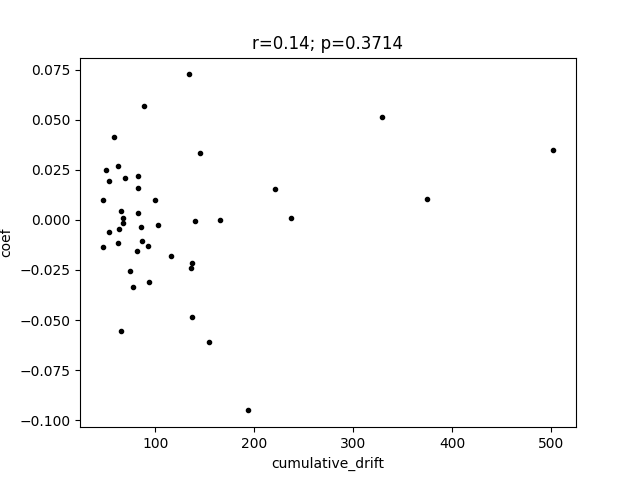

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<IPython.core.display.Javascript object>


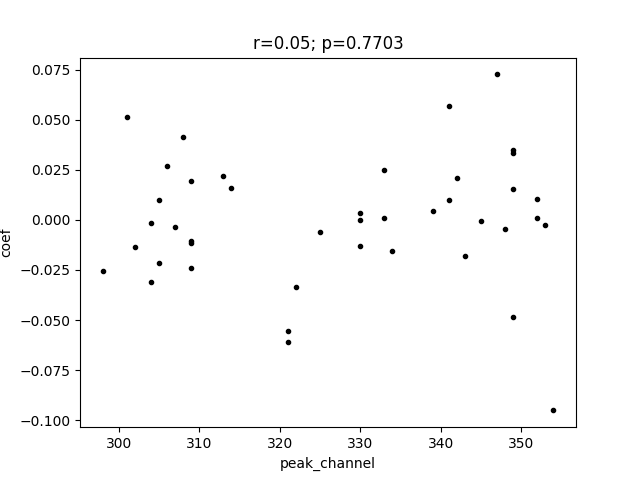

<IPython.core.display.Javascript object>


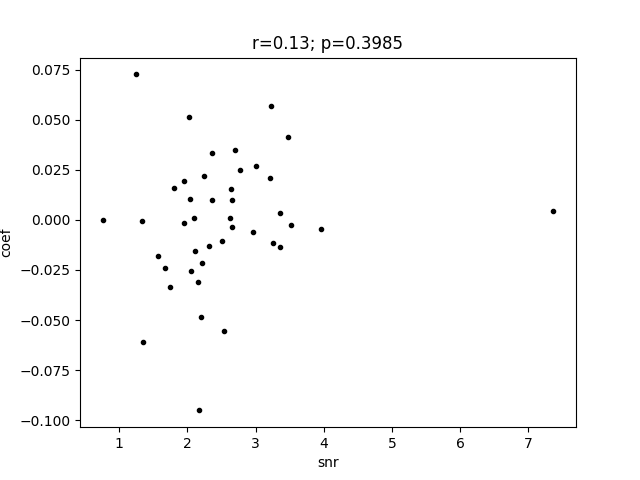

<IPython.core.display.Javascript object>


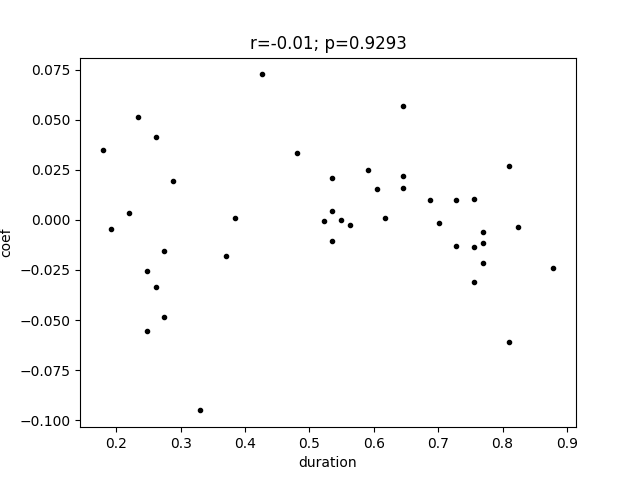

<IPython.core.display.Javascript object>


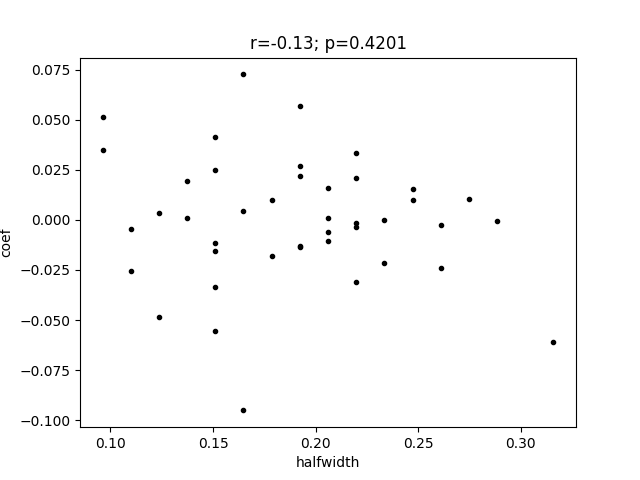

<IPython.core.display.Javascript object>


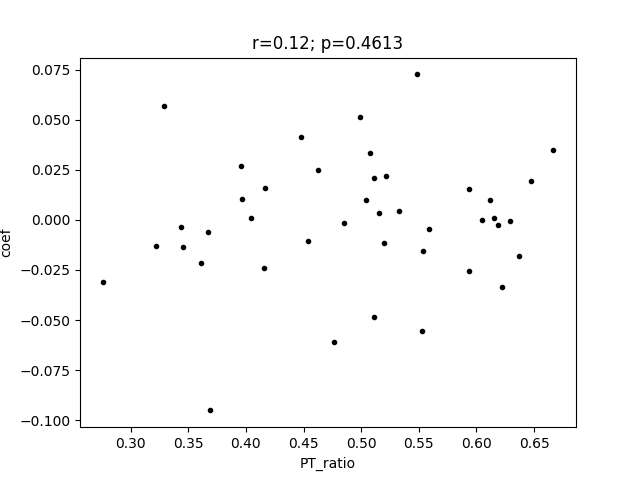

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15200\4095989189.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots()


<IPython.core.display.Javascript object>


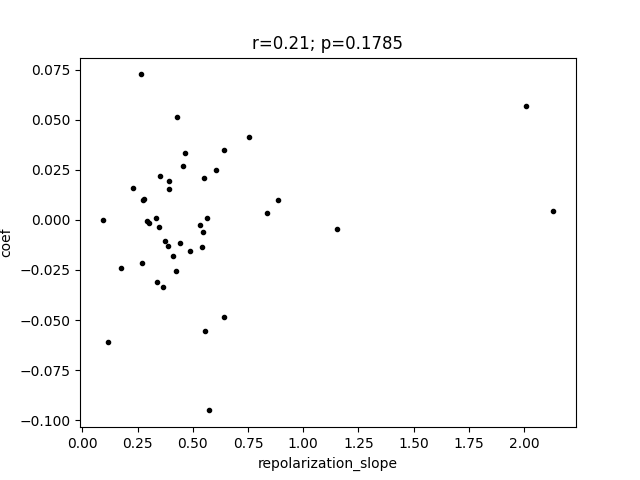

<IPython.core.display.Javascript object>


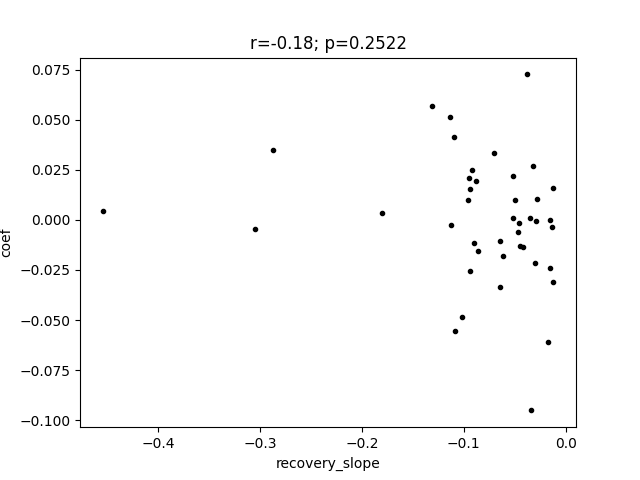

<IPython.core.display.Javascript object>


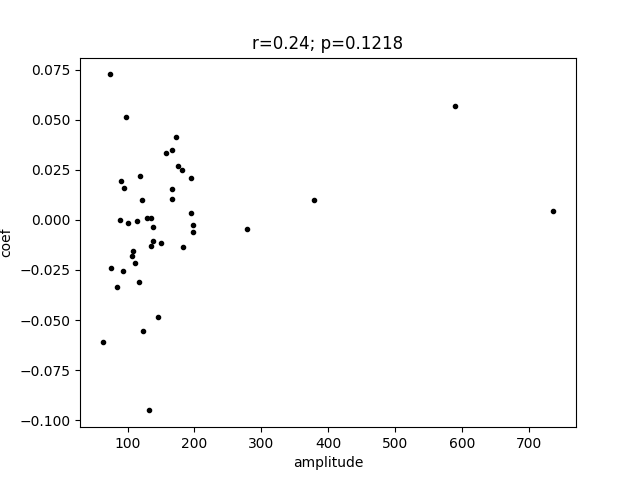

<IPython.core.display.Javascript object>


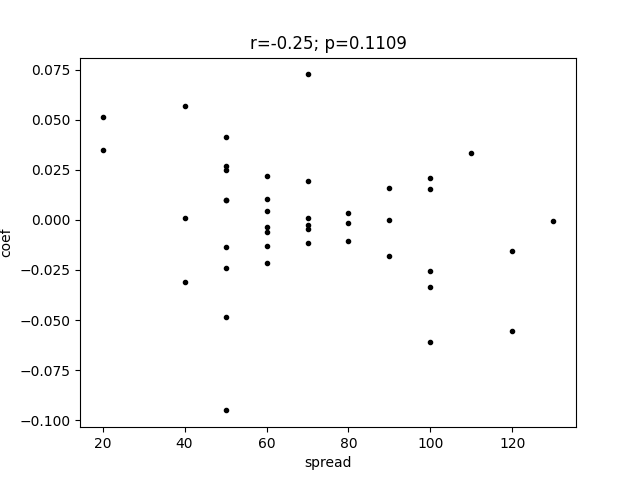

<IPython.core.display.Javascript object>


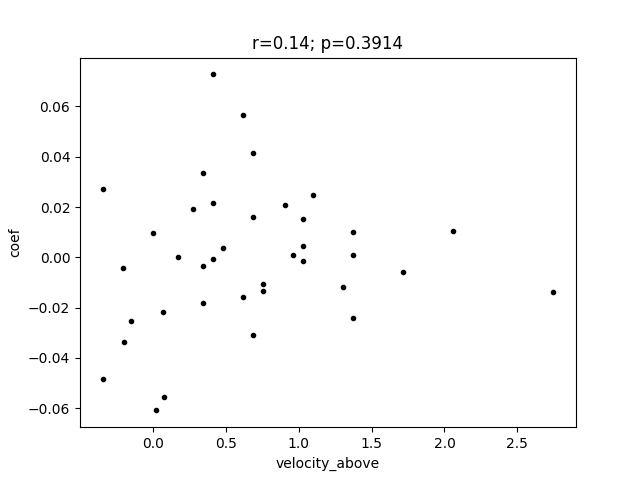

<IPython.core.display.Javascript object>


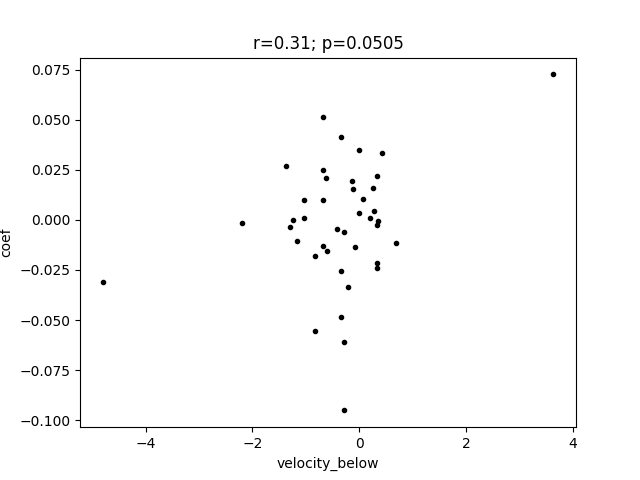

<IPython.core.display.Javascript object>


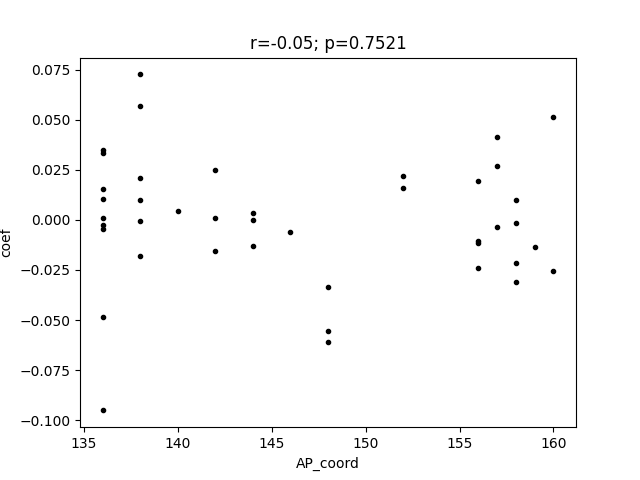

<IPython.core.display.Javascript object>


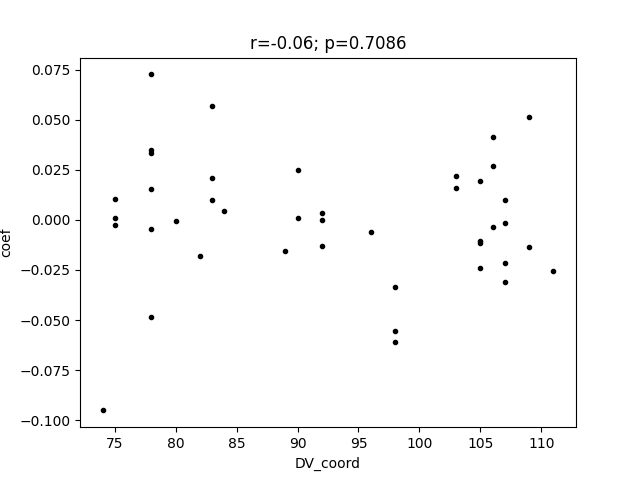

<IPython.core.display.Javascript object>


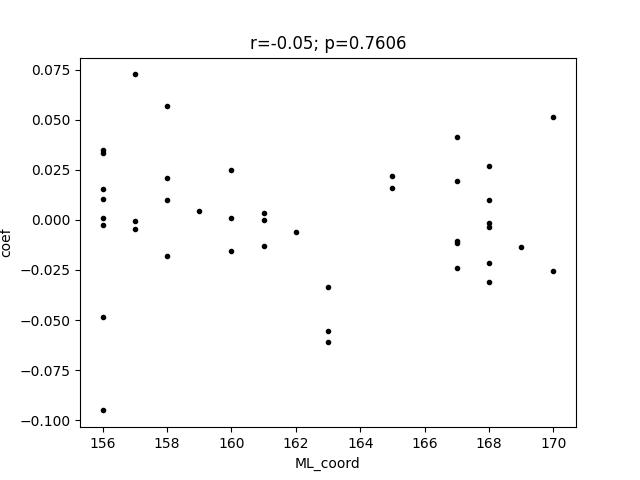

<IPython.core.display.Javascript object>


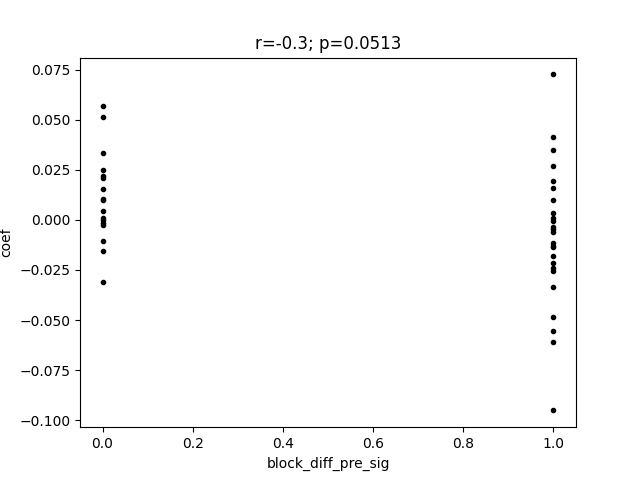

<IPython.core.display.Javascript object>


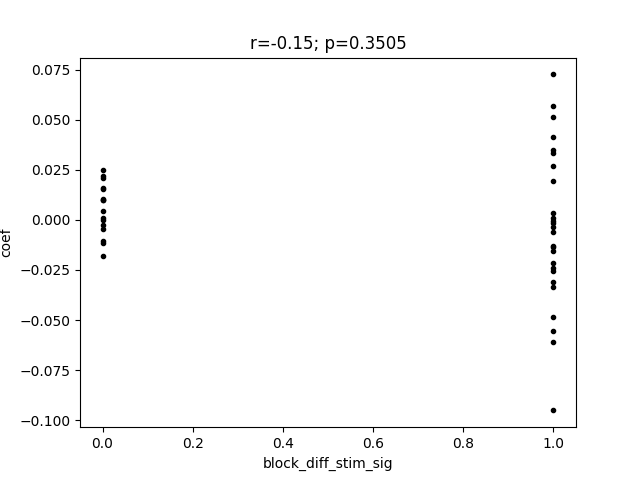

<IPython.core.display.Javascript object>


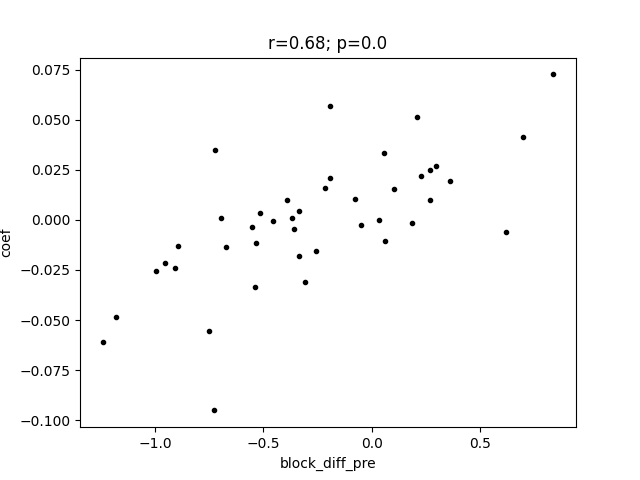

<IPython.core.display.Javascript object>


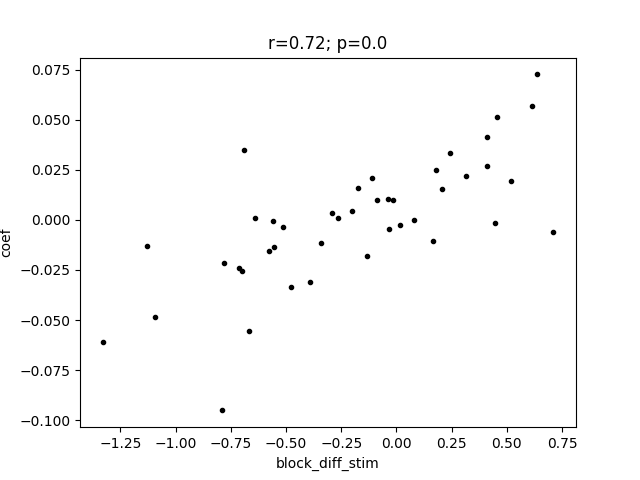

In [82]:
all_metrics=MOs_units.columns.values
MOs_ind=sessions[0].good_units['area'].str.contains("MOs").values

for mm in all_metrics:
    
    if 'area' in mm:
        continue
    
    nan_ind=MOs_units[mm].isnull()
    
    r,p=st.pearsonr(MOs_units[mm][~nan_ind],coef_mean[MOs_ind][~nan_ind.values])
    
    if np.isnan(r):
        continue
    
    
    fig,ax=plt.subplots()
    ax.plot(MOs_units[mm],coef_mean[MOs_ind],'k.')
    ax.set_xlabel(mm)
    ax.set_ylabel('coef')
    
    ax.set_title('r='+str(np.round(r,decimals=2))+'; p='+str(np.round(p,decimals=4)))
    

In [80]:
nan_ind.values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
~nan_ind.values
coef_mean.shape
MOs_ind.shape

In [ ]:
MOs_units

In [ ]:
'area' in mm

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<IPython.core.display.Javascript object>


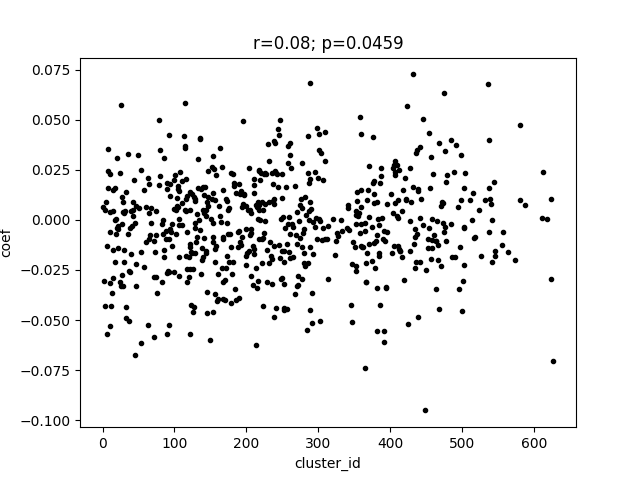

<IPython.core.display.Javascript object>


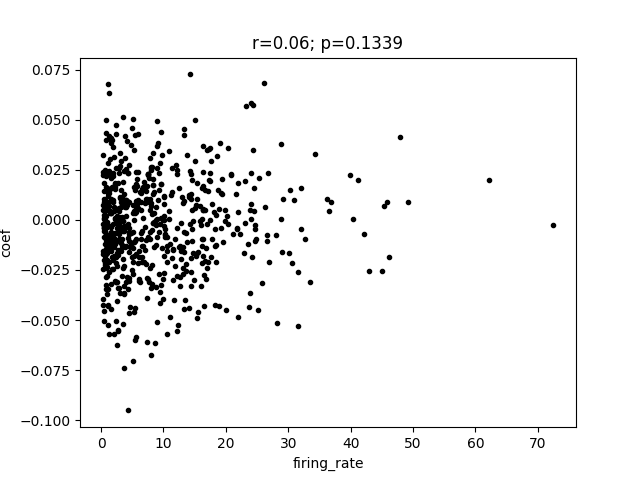

<IPython.core.display.Javascript object>


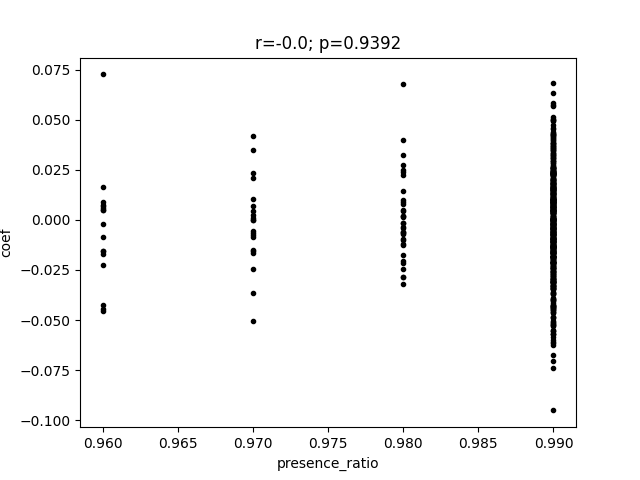

<IPython.core.display.Javascript object>


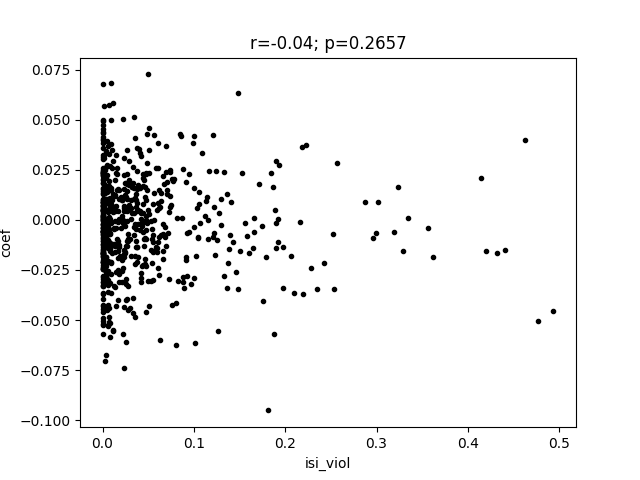

<IPython.core.display.Javascript object>


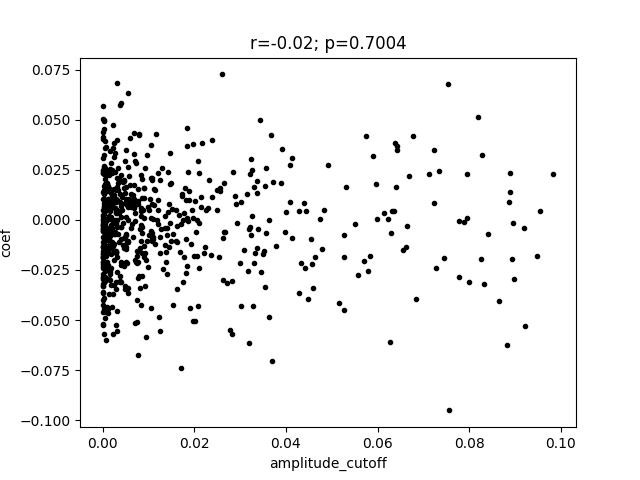

<IPython.core.display.Javascript object>


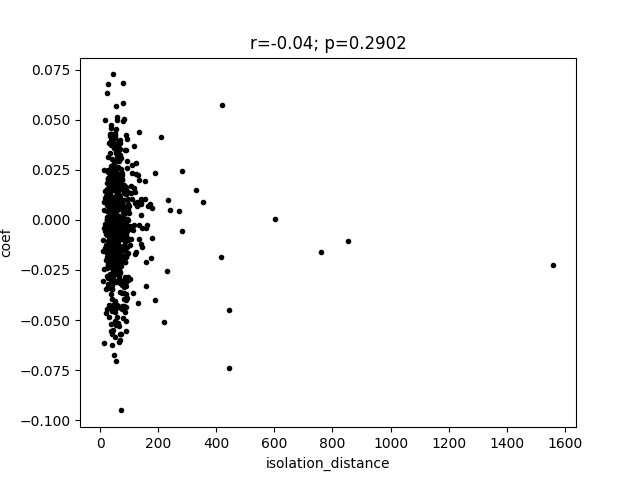

<IPython.core.display.Javascript object>


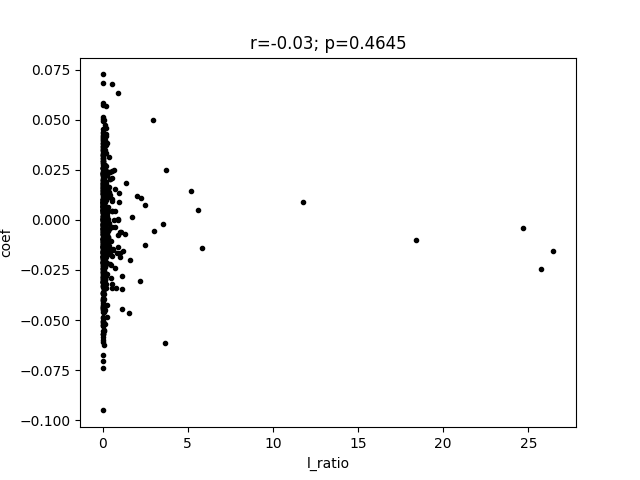

<IPython.core.display.Javascript object>


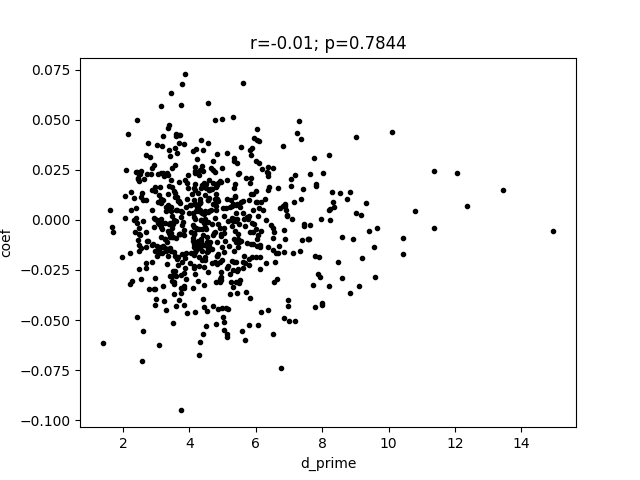

<IPython.core.display.Javascript object>


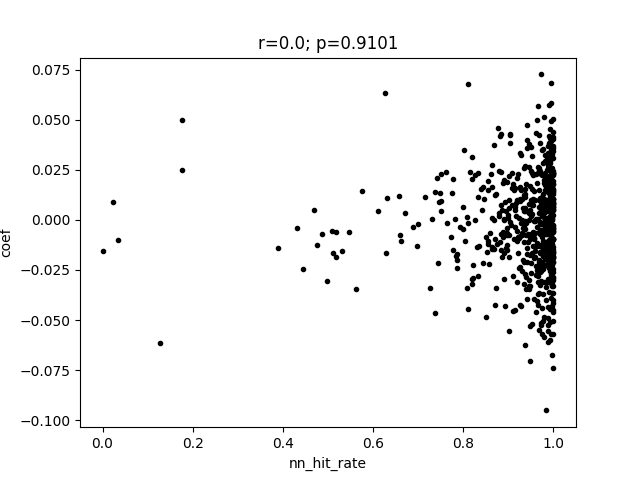

<IPython.core.display.Javascript object>


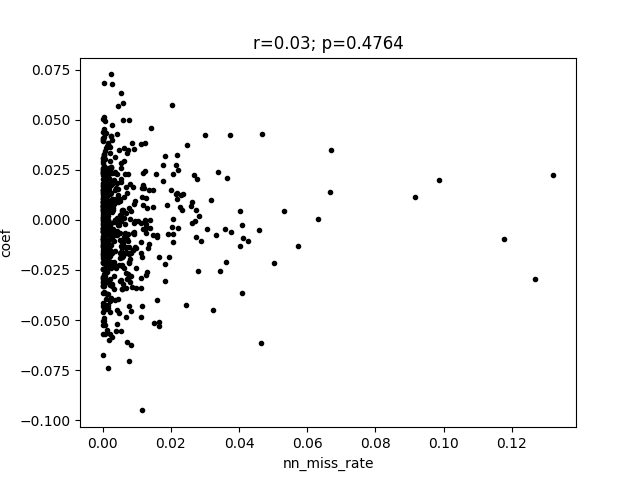

<IPython.core.display.Javascript object>


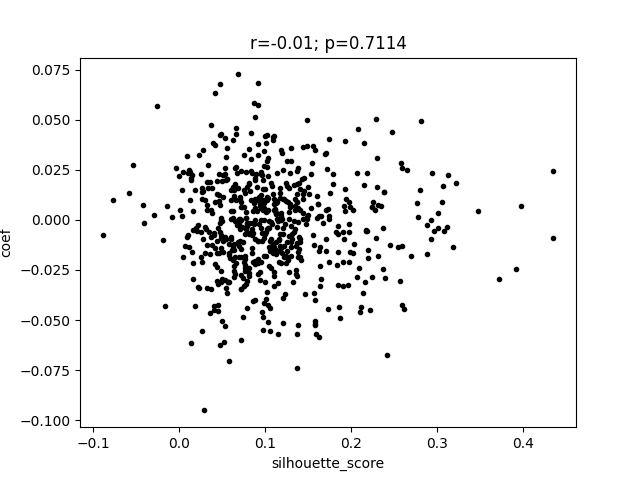

<IPython.core.display.Javascript object>


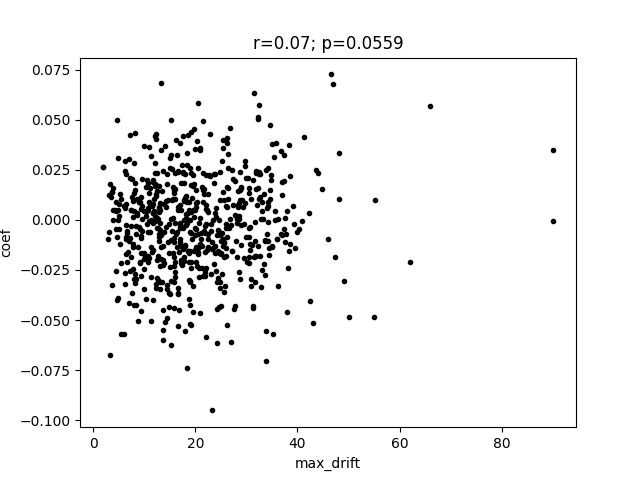

<IPython.core.display.Javascript object>


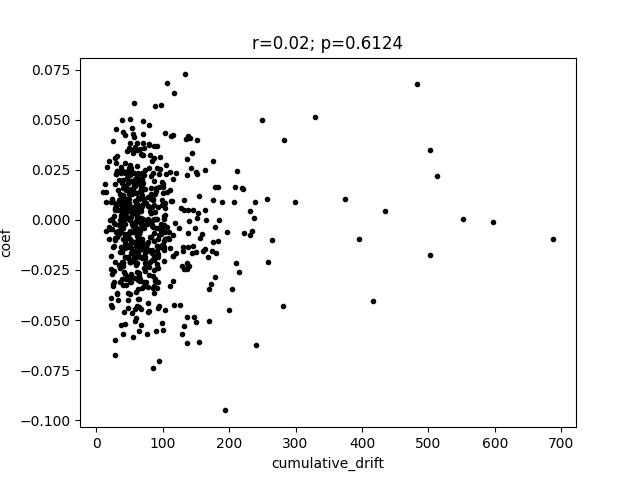

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<IPython.core.display.Javascript object>


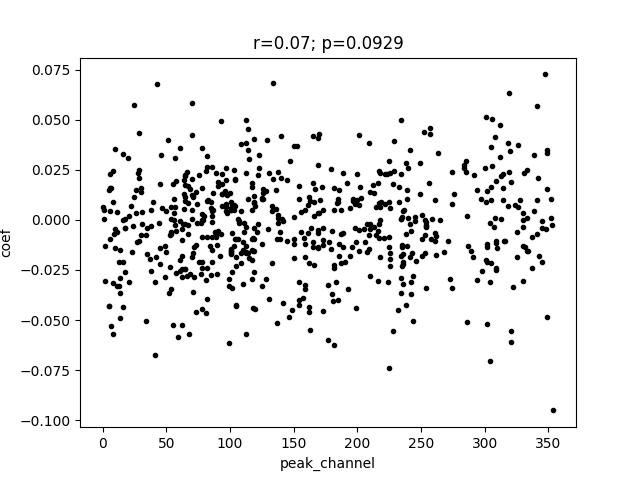

<IPython.core.display.Javascript object>


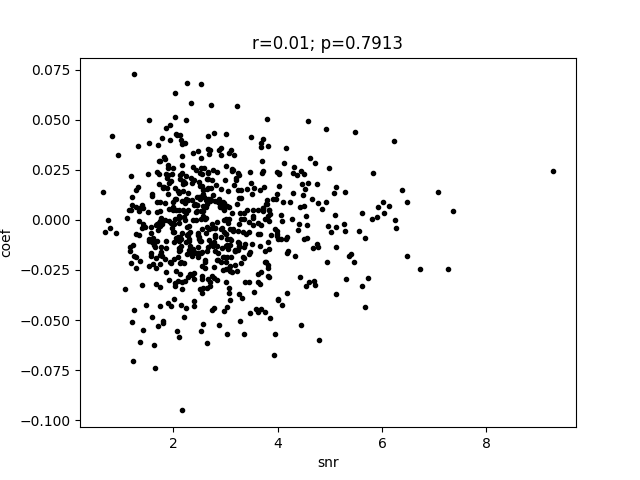

<IPython.core.display.Javascript object>


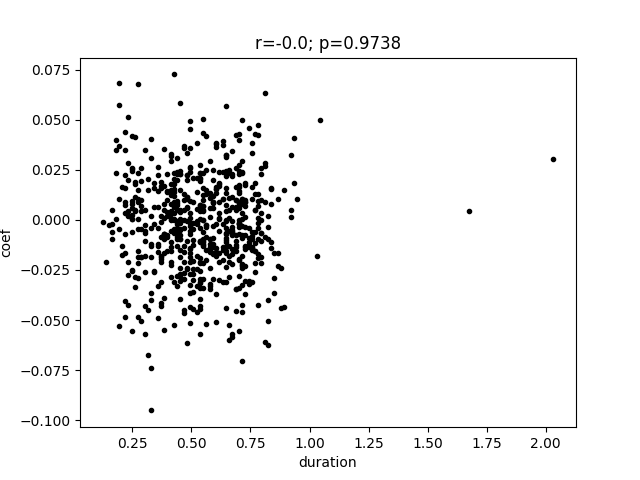

<IPython.core.display.Javascript object>


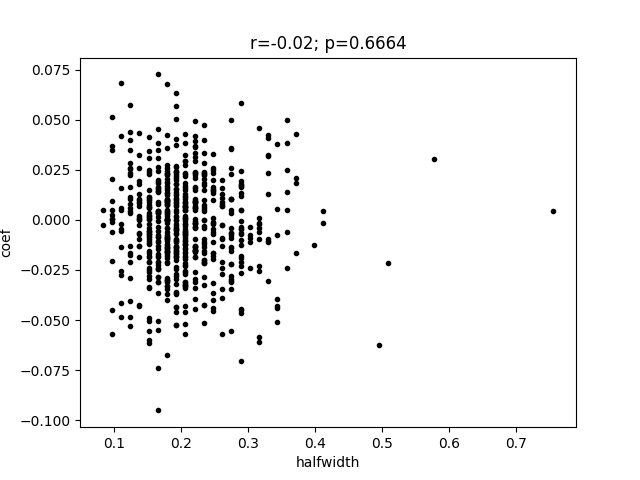

<IPython.core.display.Javascript object>


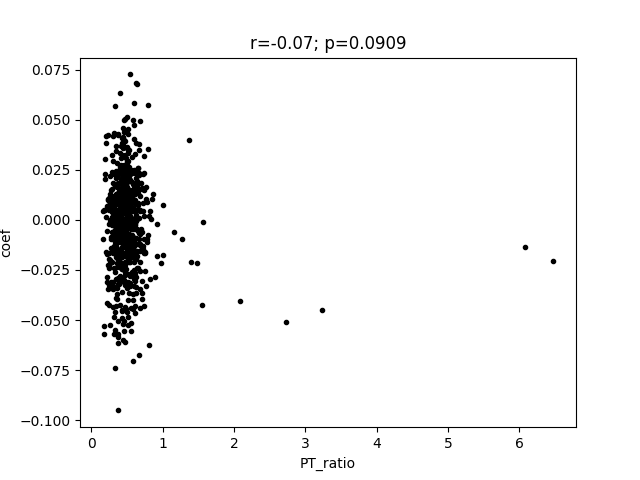

<IPython.core.display.Javascript object>


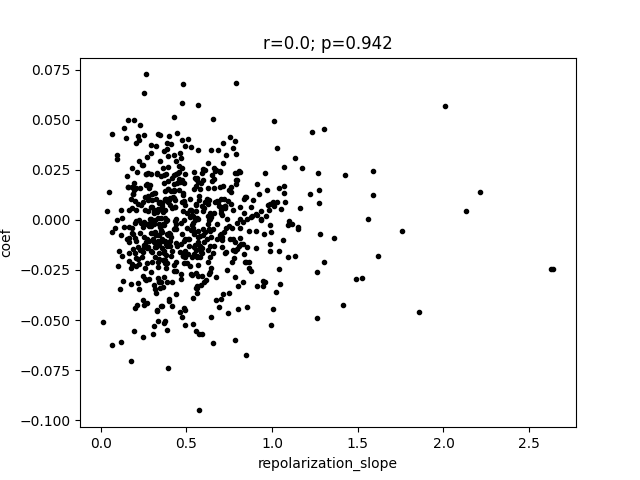

<IPython.core.display.Javascript object>


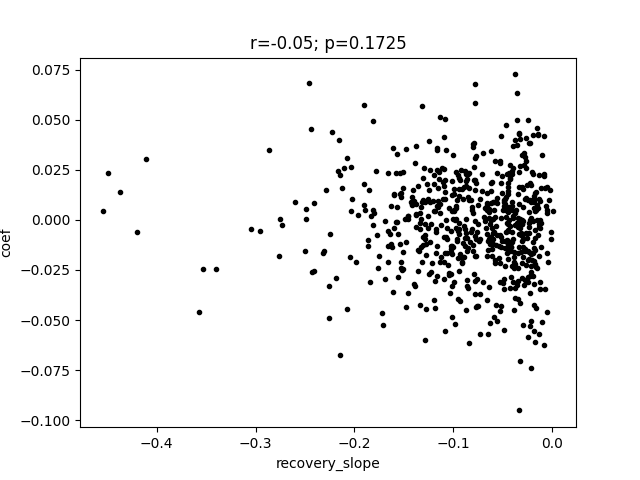

<IPython.core.display.Javascript object>


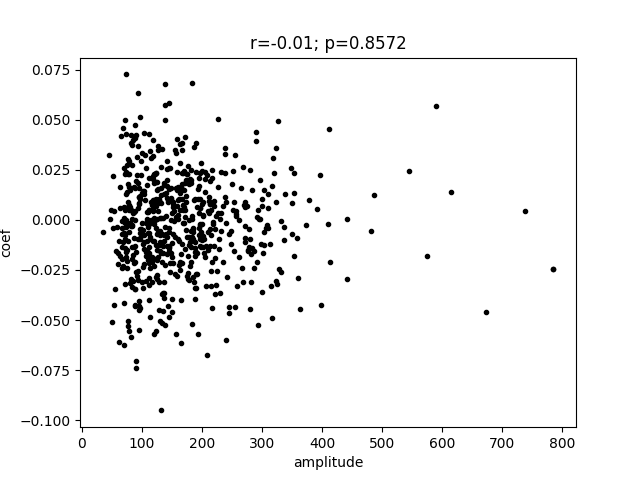

<IPython.core.display.Javascript object>


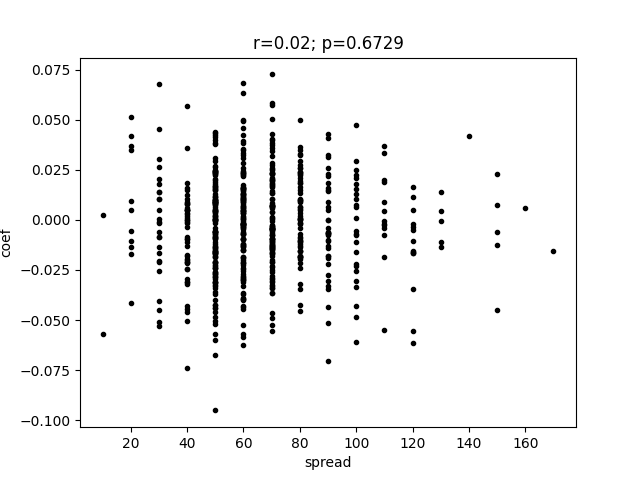

<IPython.core.display.Javascript object>


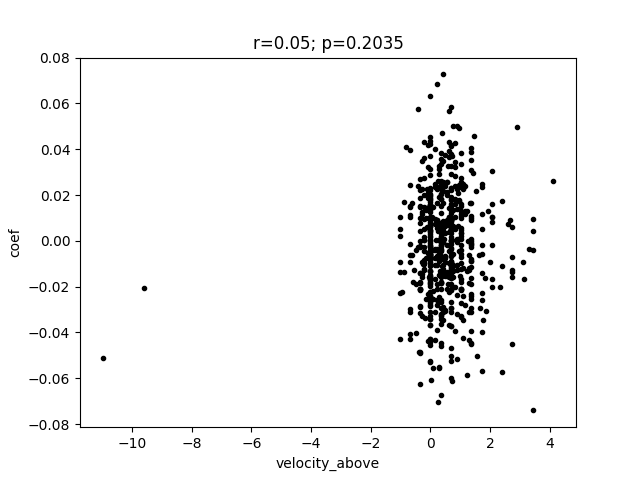

<IPython.core.display.Javascript object>


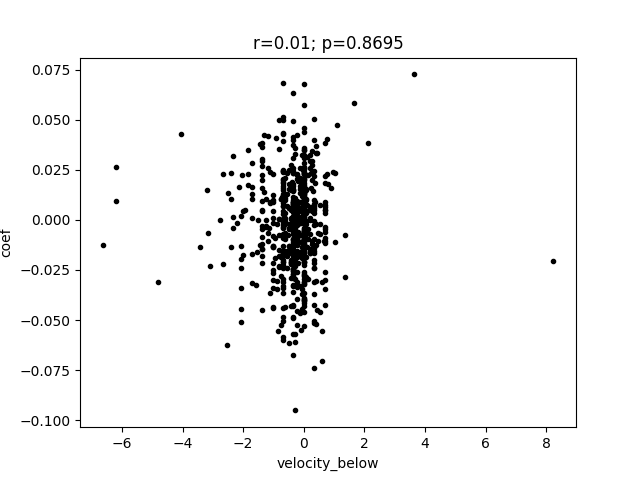

<IPython.core.display.Javascript object>


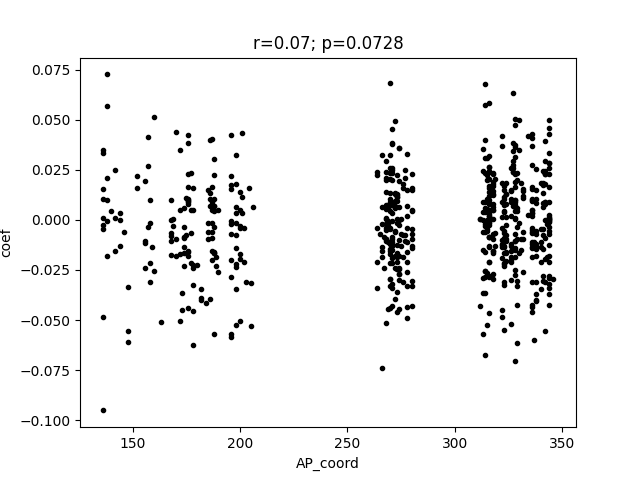

<IPython.core.display.Javascript object>


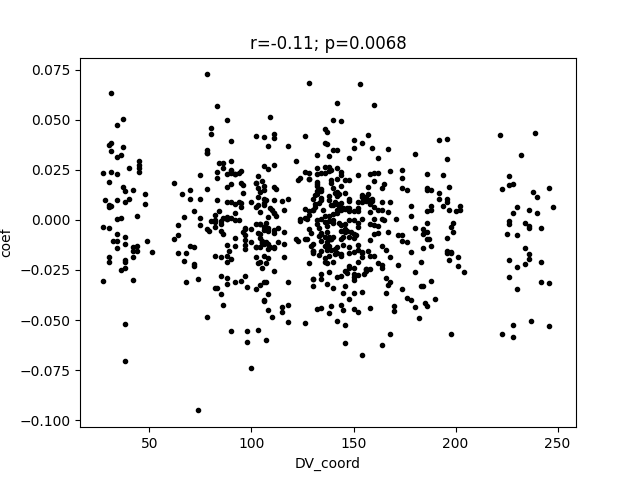

<IPython.core.display.Javascript object>


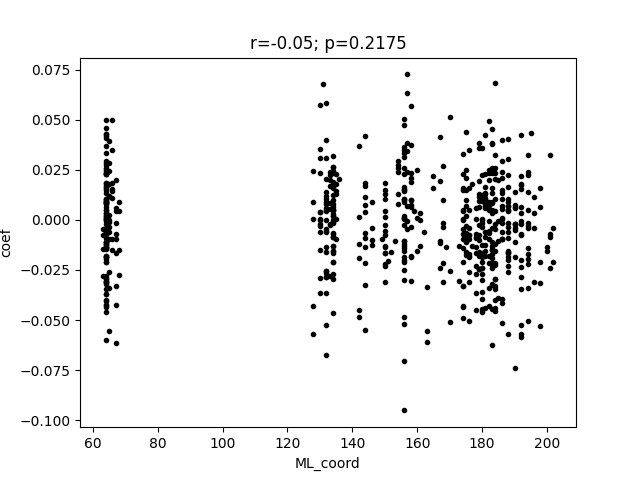

<IPython.core.display.Javascript object>


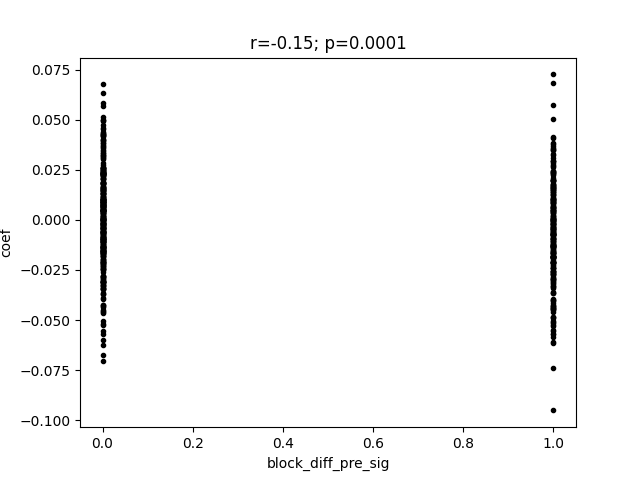

<IPython.core.display.Javascript object>


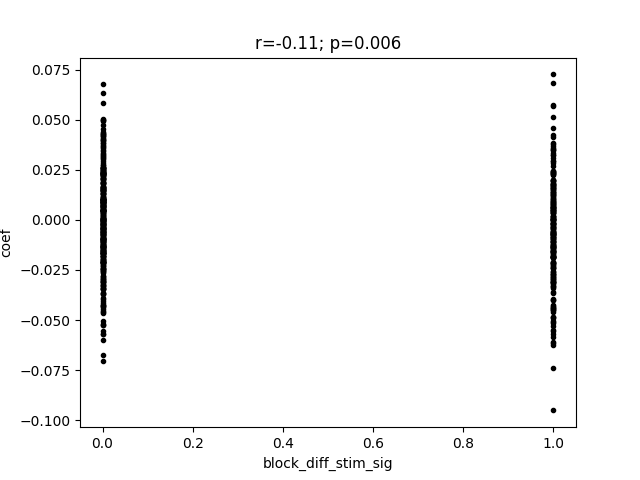

<IPython.core.display.Javascript object>


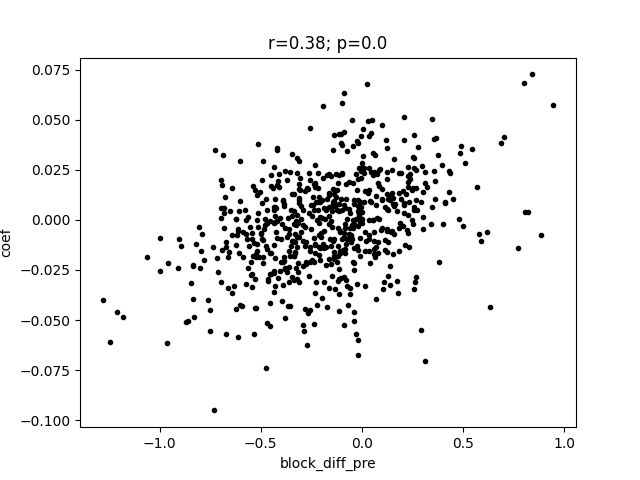

<IPython.core.display.Javascript object>


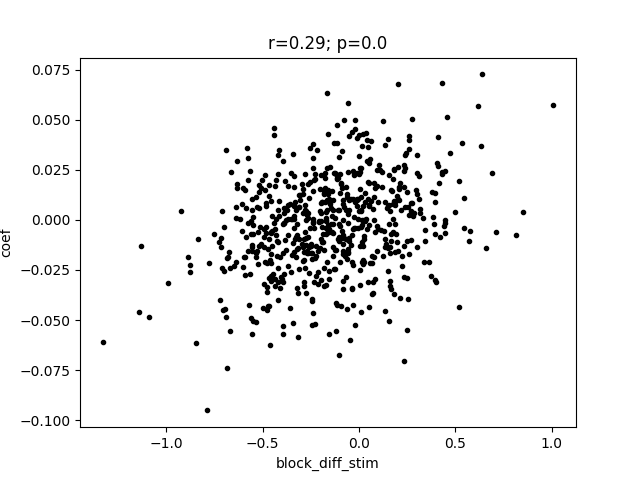

In [87]:
units=sessions[0].good_units
all_metrics=units.columns.values

for mm in all_metrics:
    
    if ('area' in mm)|('probe' in mm):
        continue
    
    nan_ind=units[mm].isnull()
    
    r,p=st.pearsonr(units[mm][~nan_ind],coef_mean[~nan_ind.values])
    
    if np.isnan(r):
        continue
    
    fig,ax=plt.subplots()
    ax.plot(units[mm],coef_mean,'k.')
    ax.set_xlabel(mm)
    ax.set_ylabel('coef')
    ax.set_title('r='+str(np.round(r,decimals=2))+'; p='+str(np.round(p,decimals=4)))
    

In [89]:

sessions[0].good_units['decoder_coef_mean']=coef_mean

<IPython.core.display.Javascript object>


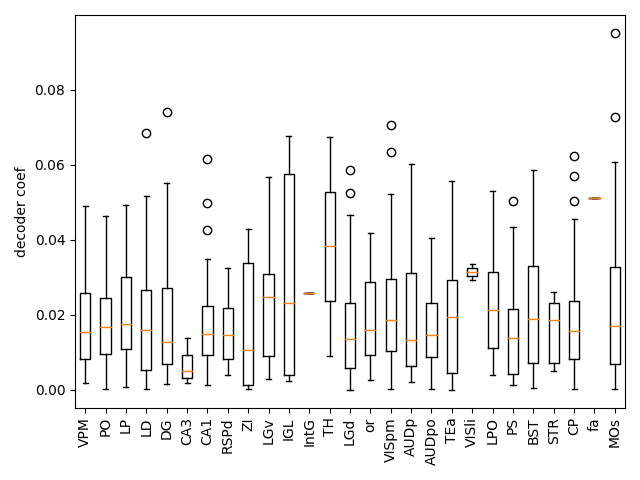

In [135]:
units=sessions[0].good_units
unique_areas=units['area_short'].unique()
area_coefs=[]
for ia, aa in enumerate(unique_areas):
    area_units=units.query('area_short==@aa')
    area_coefs.append(np.abs(area_units['decoder_coef_mean'].values))
    
fig,ax=plt.subplots(1,1)

ax.boxplot(area_coefs)
ax.set_xticks(np.arange(1,len(unique_areas)+1))
ax.set_xticklabels(unique_areas,rotation=90)
ax.set_ylabel('decoder coef')
fig.tight_layout()

In [129]:
units=sessions[0].good_units
unique_areas=units['area_short'].unique()
area_coefs=[]
prestim_block_diffs=[]
stim_block_diffs=[]

r_pre_area=np.full(len(unique_areas),np.nan)
p_pre_area=np.full(len(unique_areas),np.nan)
r_stim_area=np.full(len(unique_areas),np.nan)
p_stim_area=np.full(len(unique_areas),np.nan)

for ia, aa in enumerate(unique_areas):
    area_units=units.query('area_short==@aa')
    if len(area_units)<3:
        continue
    area_coefs.append(area_units['decoder_coef_mean'].values)
    prestim_block_diffs.append(area_units['block_diff_pre'].values)
    stim_block_diffs.append(area_units['block_diff_stim'].values)
    
    r_pre,p_pre=st.pearsonr(area_coefs[-1],prestim_block_diffs[-1])
    r_stim,p_stim=st.pearsonr(area_coefs[-1],stim_block_diffs[-1])
    
    r_pre_area[ia]=r_pre
    p_pre_area[ia]=p_pre
    
    r_stim_area[ia]=r_stim
    p_stim_area[ia]=p_stim
    


<IPython.core.display.Javascript object>


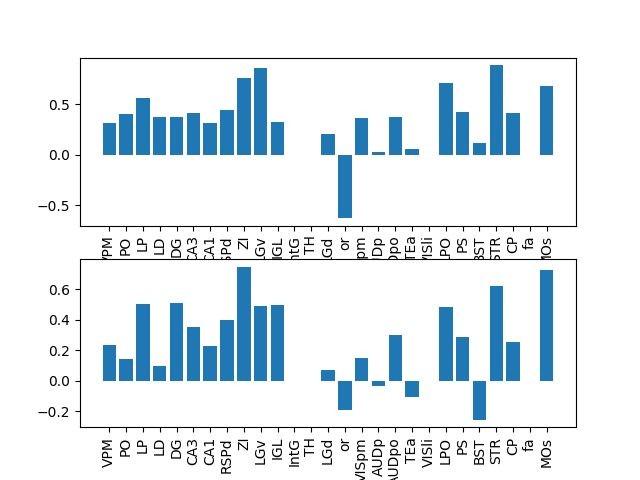

[Text(0, 0, 'VPM'),
 Text(1, 0, 'PO'),
 Text(2, 0, 'LP'),
 Text(3, 0, 'LD'),
 Text(4, 0, 'DG'),
 Text(5, 0, 'CA3'),
 Text(6, 0, 'CA1'),
 Text(7, 0, 'RSPd'),
 Text(8, 0, 'ZI'),
 Text(9, 0, 'LGv'),
 Text(10, 0, 'IGL'),
 Text(11, 0, 'IntG'),
 Text(12, 0, 'TH'),
 Text(13, 0, 'LGd'),
 Text(14, 0, 'or'),
 Text(15, 0, 'VISpm'),
 Text(16, 0, 'AUDp'),
 Text(17, 0, 'AUDpo'),
 Text(18, 0, 'TEa'),
 Text(19, 0, 'VISli'),
 Text(20, 0, 'LPO'),
 Text(21, 0, 'PS'),
 Text(22, 0, 'BST'),
 Text(23, 0, 'STR'),
 Text(24, 0, 'CP'),
 Text(25, 0, 'fa'),
 Text(26, 0, 'MOs')]

In [134]:
fig,ax=plt.subplots(2,1)
ax[0].bar(np.arange(0,len(unique_areas)),r_pre_area)
ax[1].bar(np.arange(0,len(unique_areas)),r_stim_area)


ax[0].set_xticks(np.arange(0,len(unique_areas)))
ax[0].set_xticklabels(unique_areas,rotation=90)

ax[1].set_xticks(np.arange(0,len(unique_areas)))
ax[1].set_xticklabels(unique_areas,rotation=90)

In [128]:
r_pre_area

[0.3122363214631292,
 0.3994234956187354,
 0.563870899300986,
 0.3685432856561402,
 0.37204510253822715,
 0.40845937383957076,
 0.3104200520550661,
 0.4438195609174555,
 0.7584388630077386,
 0.8590600731257341,
 0.3248736833461658,
 0.20230775821121977,
 -0.6266398869168679,
 0.35844715262741544,
 0.023420152219909954,
 0.37640241657694107,
 0.05292596369790667,
 0.709840644719203,
 0.42227037076099505,
 0.11921622630482814,
 0.8839279376480298,
 0.41087093766870836,
 0.683199367985371]

In [99]:
area_units['decoder_coef_mean'].values

array([-0.0253147 ,  0.05152129, -0.0136819 , -0.00164904, -0.0309602 ,
       -0.02169683,  0.00983041,  0.0269784 , -0.00350372,  0.04164347,
        0.01929911, -0.01170877, -0.02412986, -0.01076841,  0.02178986,
        0.01590241, -0.0608465 , -0.05548305, -0.03367203, -0.00591789,
        0.00361932, -0.013218  ,  0.00018687,  0.00086957,  0.02489112,
       -0.01571109,  0.00460378,  0.00998089,  0.05671414,  0.02097719,
       -0.01798085, -0.00055762,  0.07270909, -0.00434651,  0.03340515,
        0.03511989,  0.01529931, -0.04840639,  0.00077631,  0.01060886,
       -0.00273781, -0.09516116])

In [ ]:
#change across timepoints??

In [ ]:
#any patterns in which units are more important?